In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from random import sample
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
#for adding heavy chain
complementator = str.maketrans("ACGT", "TGCA") 

In [4]:
df_category_cancers = pd.read_csv('../data/processed/df_category_cancers_pqs.csv')

In [5]:
ref_annot = pd.read_csv('../data/raw/ref_annot.csv')
g4pqsconf = pd.read_csv('../data/processed/g4pqsconf.csv')
df_loop_cancer = pd.read_csv('../data/processed/df_loop_cancer_pqs.csv')
df_15_col_cancer = pd.read_csv('../data/processed/df_15_col_cancer_pqs.csv')

In [6]:
df_tetrads_cancer = pd.read_csv('../data/processed/df_tetrads_cancer_pqs.csv')

In [193]:
df_n_col_cancer = pd.read_csv('../data/processed/df_n_col_cancer_pqs.csv')

In [7]:
df_cancers = pd.read_csv('../data/raw/mutations.csv') 

In [8]:
def get_norm_mutspec(df):
    
    normMut = pd.DataFrame()
    
    normMut[['A>C','A>G','A>T']] = df[['A>C','A>G','A>T']].div(df['A'], axis=0)
    normMut[['C>A','C>G','C>T']] = df[['C>A','C>G','C>T']].div(df['C'], axis=0)
    normMut[['G>A', 'G>C', 'G>T']] = df[['G>A', 'G>C', 'G>T']].div(df['G'], axis=0)
    normMut[['T>A', 'T>C', 'T>G']] = df[['T>A', 'T>C', 'T>G']].div(df['T'], axis=0)
    
    normMut = normMut.fillna(0)
    normMut = normMut.div(normMut.sum(axis=1), axis=0)
    
    normMut.columns = normMut.columns.str.translate(complementator)
    
    return normMut

In [9]:
def add_col_to_norm_mutspec(normMut:pd.DataFrame, df:pd.DataFrame):
    normMut.insert(0, 'G4_id', df['G4_id'])
    normMut.insert(1, 'side', df['side'])
    normMut = normMut.fillna(0)
    return normMut

In [10]:
norm_15_col = add_col_to_norm_mutspec(get_norm_mutspec(df_15_col_cancer).fillna(0), df_15_col_cancer)
norm_loop = add_col_to_norm_mutspec(get_norm_mutspec(df_loop_cancer).fillna(0), df_loop_cancer)
norm_tetrads = add_col_to_norm_mutspec(get_norm_mutspec(df_tetrads_cancer).fillna(0), df_tetrads_cancer)

In [11]:
norm_15_col['location'] = norm_15_col['side'].str[:2].astype(int)
norm_loop['location'] = 0
norm_tetrads['location'] = 0

In [67]:
norm_15_col.head()

G4_id   side  T>G  T>C  T>A      G>T  G>C       G>A       C>T       C>G  \
0      1  15_up  0.0  0.0  0.0  0.00000  0.0  0.000000  0.000000  0.000000   
1      2  15_up  0.0  0.0  0.0  0.04000  0.0  0.160000  0.720000  0.000000   
2      3  15_up  0.0  0.0  0.0  0.00000  0.0  0.923077  0.000000  0.000000   
3      4  15_up  0.0  0.0  0.0  0.02439  0.0  0.024390  0.073171  0.292683   
4      5  15_up  0.0  0.0  0.0  0.00000  0.0  0.230769  0.461538  0.153846   

        C>A  A>T       A>G  A>C  location  
0  0.000000  0.0  1.000000  0.0        15  
1  0.000000  0.0  0.080000  0.0        15  
2  0.000000  0.0  0.076923  0.0        15  
3  0.073171  0.0  0.512195  0.0        15  
4  0.000000  0.0  0.153846  0.0        15

In [68]:
norm_loop.head()

G4_id   side  T>G       T>C  T>A  G>T  G>C       G>A       C>T  C>G  \
0      1  loops  0.0  0.000000  0.0  1.0  0.0  0.000000  0.000000  0.0   
1      2  loops  0.0  0.000000  1.0  0.0  0.0  0.000000  0.000000  0.0   
2      3  loops  0.0  0.000000  0.0  0.0  0.0  0.060870  0.730435  0.0   
3      4  loops  0.0  0.068587  0.0  0.0  0.0  0.019204  0.816187  0.0   
4      5  loops  0.0  0.000000  0.0  0.0  0.0  0.000000  0.800000  0.0   

        C>A  A>T       A>G  A>C  location  
0  0.000000  0.0  0.000000  0.0         0  
1  0.000000  0.0  0.000000  0.0         0  
2  0.000000  0.0  0.208696  0.0         0  
3  0.096022  0.0  0.000000  0.0         0  
4  0.000000  0.0  0.200000  0.0         0

In [69]:
norm_tetrads.head()

G4_id     side  T>G  T>C  T>A  G>T  G>C       G>A  C>T  C>G  C>A  A>T  \
0      1  tetrads  0.0  0.0  0.0  0.0  0.0  1.000000  0.0  0.0  0.0  0.0   
1      2  tetrads  0.0  0.0  0.0  0.0  0.0  1.000000  0.0  0.0  0.0  0.0   
2      3  tetrads  0.0  0.0  0.0  0.0  0.0  0.296296  0.0  0.0  0.0  0.0   
3      4  tetrads  0.0  0.0  0.0  0.3  0.0  0.700000  0.0  0.0  0.0  0.0   
4      5  tetrads  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0   

        A>G  A>C  location  
0  0.000000  0.0         0  
1  0.000000  0.0         0  
2  0.703704  0.0         0  
3  0.000000  0.0         0  
4  1.000000  0.0         0

In [15]:
norm_merged = pd.concat([norm_15_col,norm_loop])

In [16]:
norm_merged

G4_id   side       T>G       T>C  T>A       G>T       G>C       G>A  \
0       1  15_up  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
1       2  15_up  0.000000  0.000000  0.0  0.040000  0.000000  0.160000   
2       3  15_up  0.000000  0.000000  0.0  0.000000  0.000000  0.923077   
3       4  15_up  0.000000  0.000000  0.0  0.024390  0.000000  0.024390   
4       5  15_up  0.000000  0.000000  0.0  0.000000  0.000000  0.230769   
..    ...    ...       ...       ...  ...       ...       ...       ...   
62     63  loops  0.000000  0.000000  0.0  0.000000  0.000000  0.500000   
63     64  loops  0.136143  0.034036  0.0  0.000000  0.090762  0.000000   
64     65  loops  0.020690  0.062069  0.0  0.144828  0.000000  0.289655   
65     66  loops  0.000000  0.405797  0.0  0.000000  0.000000  0.289855   
66     67  loops  0.000000  0.000000  0.0  0.000000  0.000000  0.258065   

         C>T       C>G       C>A       A>T       A>G  A>C  location  
0   0.000000  0.000000  0.000000  0.000000  1.000000  0.0        15  
1   0.720000  0.000000  0.000000  0.000000  0.080000  0.0        15  
2   0.000000  0.000000  0.000000  0.000000  0.076923  0.0        15  
3   0.073171  0.292683  0.073171  0.000000  0.512195  0.0        15  
4   0.461538  0.153846  0.000000  0.000000  0.153846  0.0        15  
..       ...       ...       ...       ...       ...  ...       ...  
62  0.000000  0.000000  0.000000  0.000000  0.500000  0.0         0  
63  0.544571  0.000000  0.000000  0.000000  0.194489  0.0         0  
64  0.000000  0.000000  0.000000  0.000000  0.482759  0.0         0  
65  0.202899  0.000000  0.000000  0.000000  0.101449  0.0         0  
66  0.096774  0.000000  0.000000  0.064516  0.580645  0.0         0  

[425 rows x 15 columns]

In [17]:
norm_merged_tetrads = pd.concat([norm_15_col,norm_tetrads])

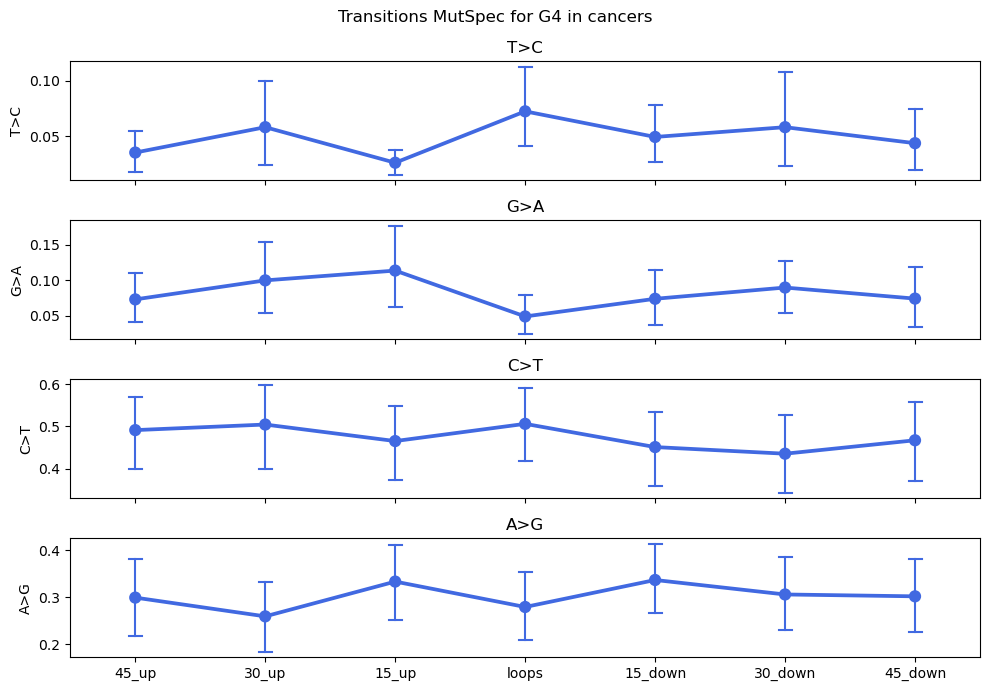

In [19]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_merged, 
                 x=norm_merged['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)


plt.suptitle('Transitions MutSpec for G4 in cancers')
plt.tight_layout()
plt.show()

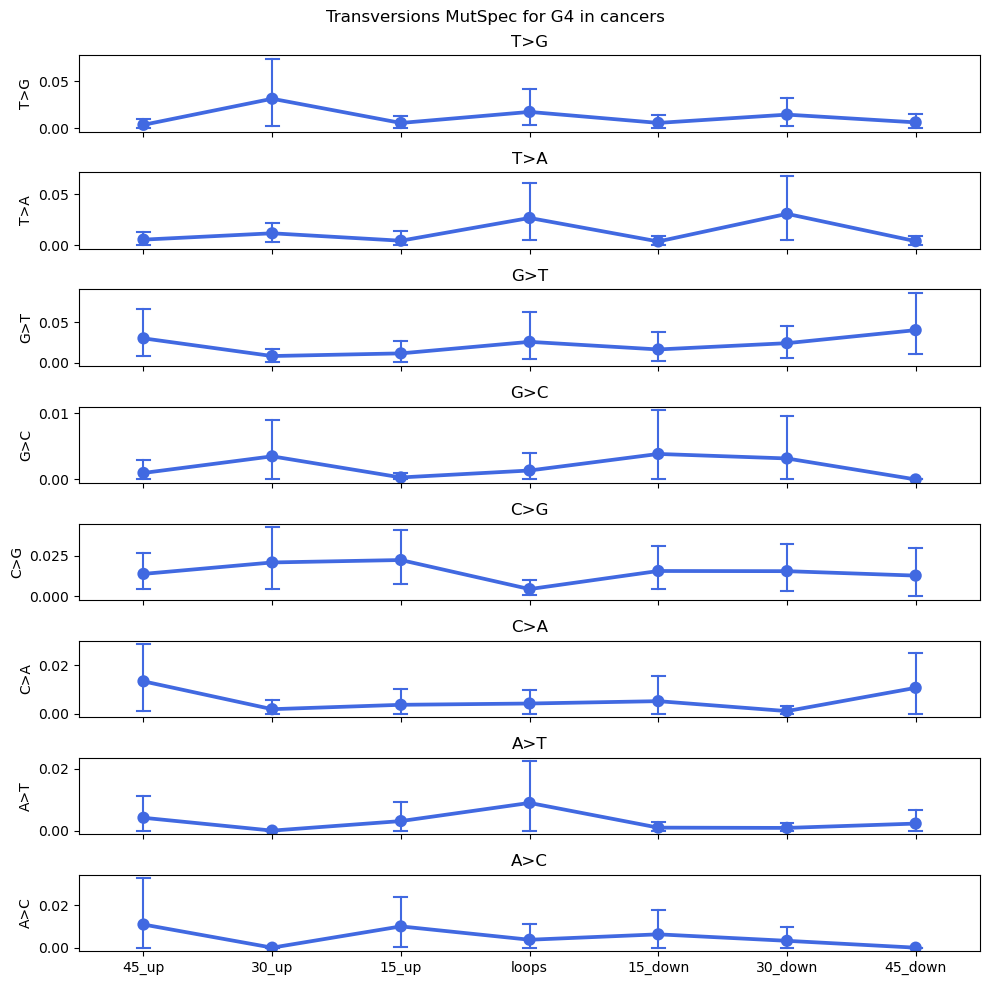

In [16]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=norm_merged, 
                 x=norm_merged['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

plt.suptitle('Transversions MutSpec for G4 in cancers')
plt.tight_layout()
plt.show()

In [15]:
df_loop_cancer['n_mut/length'] = df_loop_cancer['number_of_Mut']/df_loop_cancer['sequence'].apply(lambda x:len(x))

In [16]:
df_15_col_cancer['n_mut/length'] = df_15_col_cancer['number_of_Mut']/15

In [17]:
df_cancer_concat = pd.concat([df_loop_cancer, df_15_col_cancer]) 

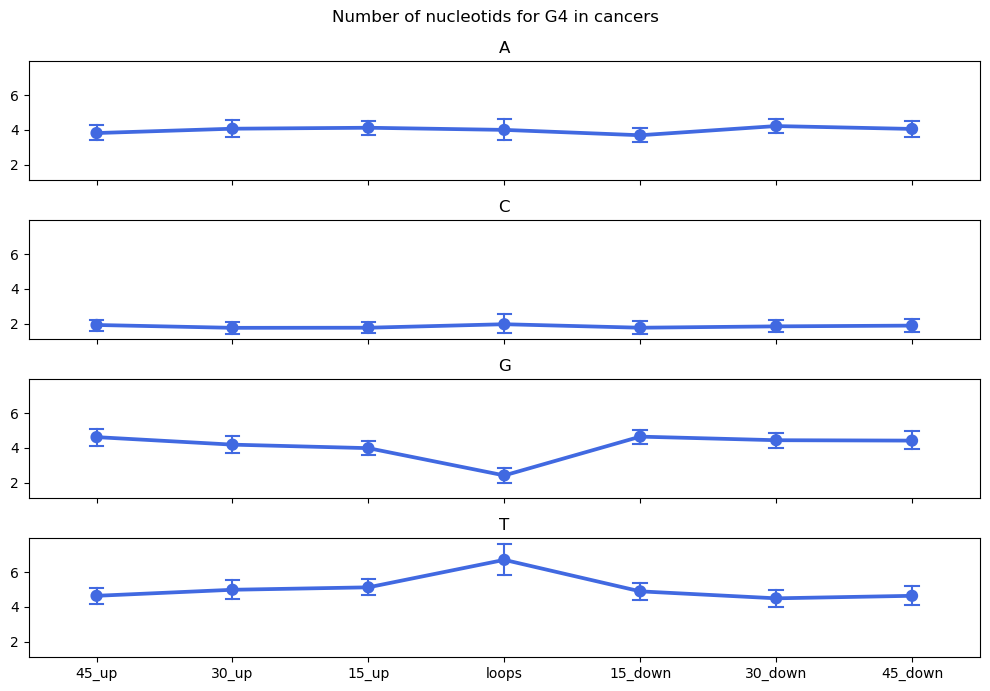

In [24]:
fig, axs = plt.subplots(4, sharex=True, sharey=True,  figsize=(10, 7))
mutations = ['T', 'G', 'C', 'A']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid'] 
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=df_cancer_concat, 
                 x=df_cancer_concat['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation.translate(complementator), xlabel=None, ylabel=None)


plt.suptitle('Number of nucleotids for G4 in cancers')
plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Number of Mut / interval length'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

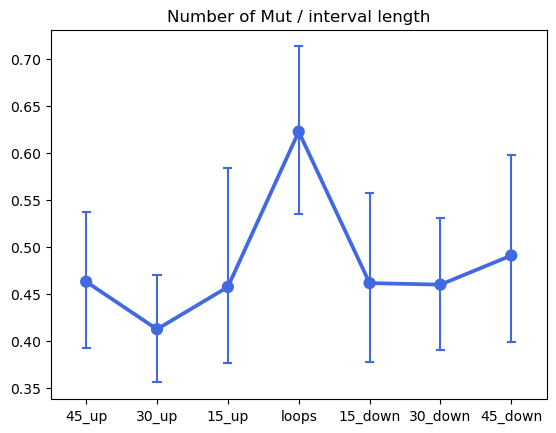

In [20]:
sns.pointplot(data=df_cancer_concat, 
                 x=df_cancer_concat['side'], y=df_cancer_concat['n_mut/length'], 
              color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title='Number of Mut / interval length', xlabel=None, ylabel=None)

[Text(0.5, 1.0, 'Number of Mut / interval length'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

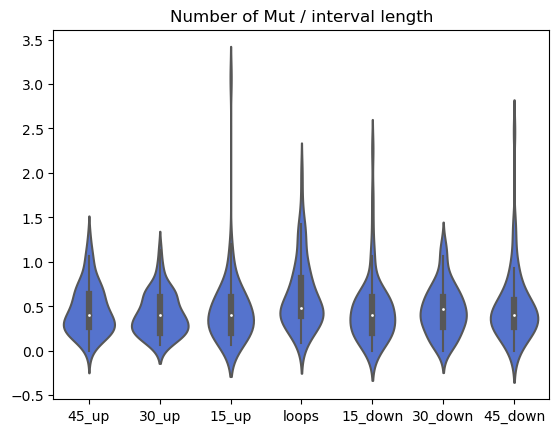

In [21]:
sns.violinplot(data=df_cancer_concat, 
                 x=df_cancer_concat['side'], y=df_cancer_concat['n_mut/length'], 
              color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title='Number of Mut / interval length', xlabel=None, ylabel=None)

In [22]:
df_cancer_concat[df_cancer_concat['n_mut/length'] > 1.5]

G4_id     side                                          positions  \
22      23    loops                                 [7403, 7407, 7408]   
64      65    loops  [16170, 16171, 16172, 16177, 16178, 16179, 161...   
62      65    15_up                                                NaN   
179      1  15_down                                                NaN   
243     67  15_down                                                NaN   
337     42  45_down                                                NaN   

            sequence    A    C    G    T  A>C  A>G  ...   G>A  G>C  G>T  T>A  \
22               ATA  2.0  0.0  0.0  1.0  4.0  2.0  ...   0.0  0.0  0.0  0.0   
64      AATATCAAAACT  7.0  2.0  0.0  3.0  1.0  3.0  ...   0.0  0.0  0.0  0.0   
62   TGACCACCTGTAGTA  4.0  4.0  3.0  4.0  0.0  2.0  ...  15.0  0.0  0.0  0.0   
179  CGCTTCTGGCCACAG  2.0  6.0  4.0  3.0  0.0  0.0  ...   6.0  0.0  0.0  0.0   
243  CTCAGATAGGGGTCC  3.0  4.0  5.0  3.0  0.0  1.0  ...  33.0  0.0  0.0  0.0   
337  AATCGCCCACGGGCT  3.0  6.0  4.0  2.0  0.0  0.0  ...  35.0  0.0  0.0  0.0   

      T>C  T>G  number_of_Mut  n_mut/length  window_start  window_end  
22    0.0  0.0            6.0      2.000000           NaN         NaN  
64   10.0  0.0           20.0      1.666667           NaN         NaN  
62    0.0  0.0           46.0      3.066667       16144.0     16159.0  
179  17.0  0.0           26.0      1.733333         315.0       330.0  
243   0.0  0.0           34.0      2.266667       16380.0     16395.0  
337   2.0  0.0           37.0      2.466667       11707.0     11722.0  

[6 rows x 24 columns]

[Text(0.5, 1.0, 'Number of Mut / interval length < 1.5'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

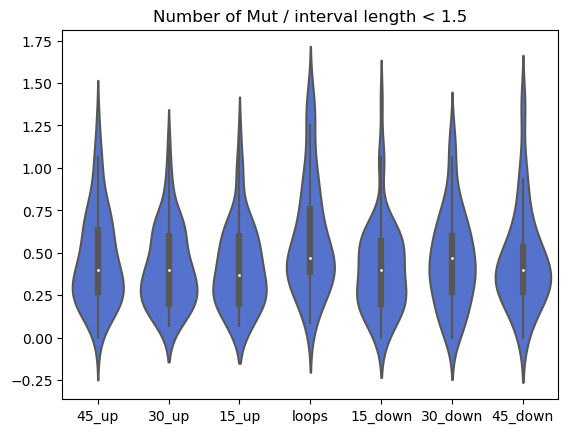

In [23]:
sns.violinplot(data=df_cancer_concat[df_cancer_concat['n_mut/length'] < 1.5], 
                 x='side', y='n_mut/length', 
              color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title='Number of Mut / interval length < 1.5', xlabel=None, ylabel=None)

[Text(0.5, 1.0, 'Mut ratio, mut/site'), Text(0.5, 0, ''), Text(0, 0.5, '')]

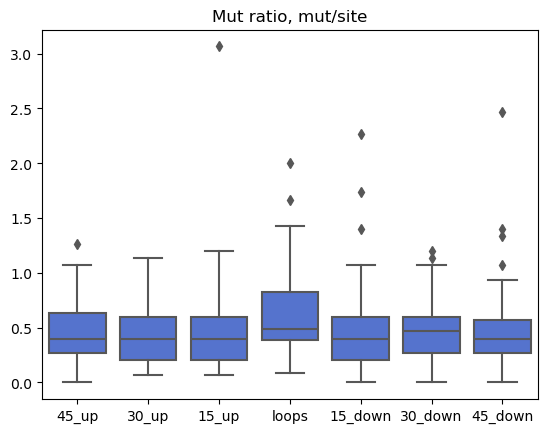

In [23]:
# Number of Mut / interval length = mut ratio
sns.boxplot(data=df_cancer_concat, 
                 x=df_cancer_concat['side'], y=df_cancer_concat['n_mut/length'], 
              color=colors[0], order=order) \
        .set(title='Mut ratio, mut/site', xlabel=None, ylabel=None)

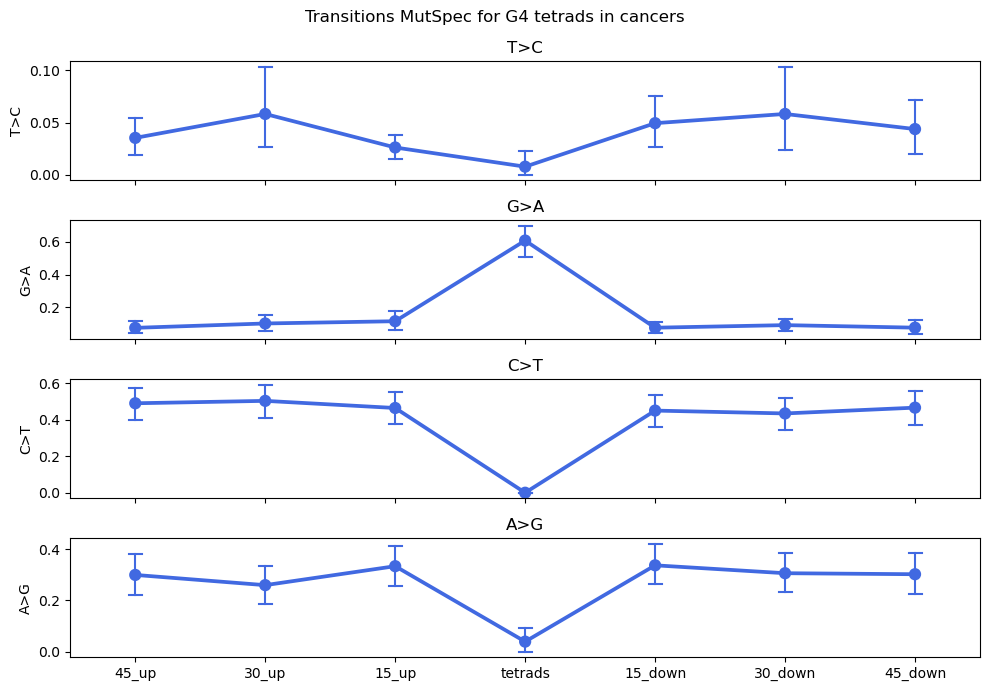

In [27]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'tetrads', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_merged_tetrads, 
                 x=norm_merged_tetrads['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)


plt.suptitle('Transitions MutSpec for G4 tetrads in cancers')
plt.tight_layout()
plt.show()

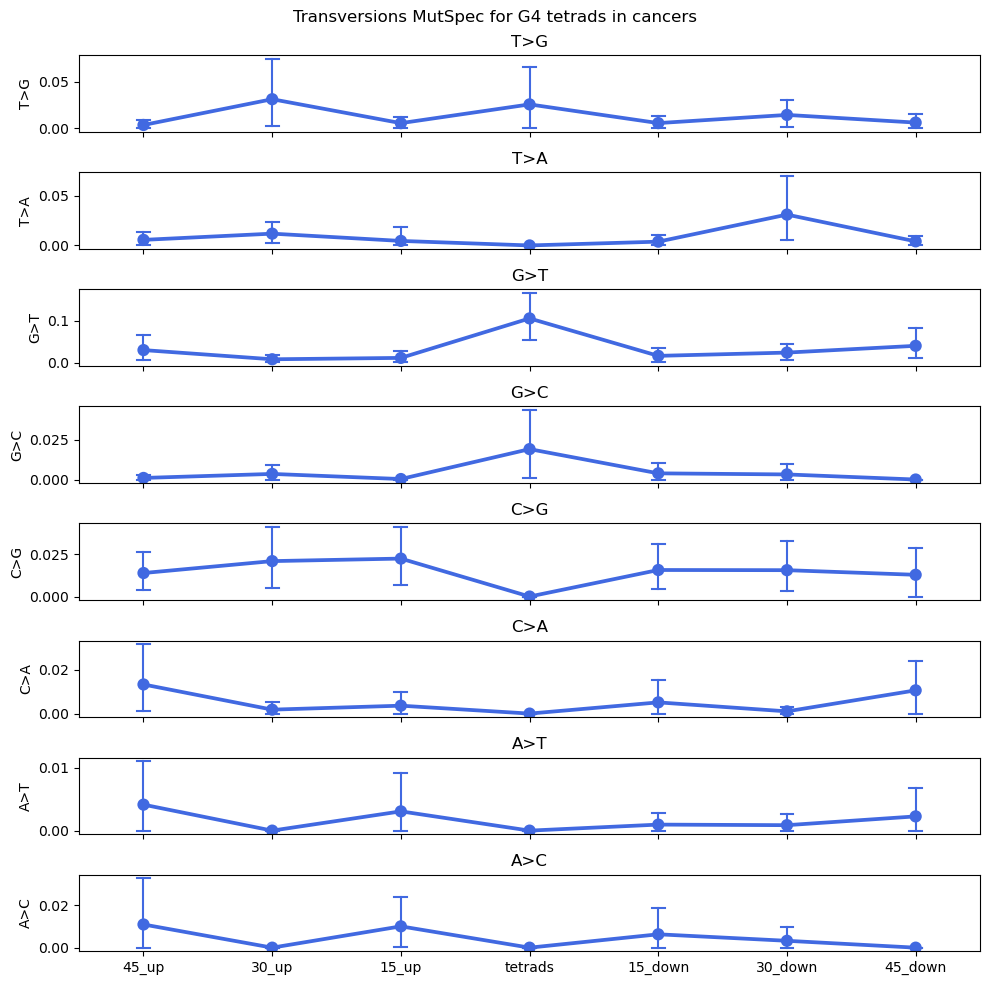

In [24]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'tetrads', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=norm_merged_tetrads, 
                 x=norm_merged_tetrads['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

plt.suptitle('Transversions MutSpec for G4 tetrads in cancers')
plt.tight_layout()
plt.show()

In [24]:
df_tetrads_cancer['n_mut/length'] = df_tetrads_cancer['number_of_Mut']/df_tetrads_cancer['sequence'].apply(lambda x:len(x))

In [25]:
df_cancer_concat_tetrads = pd.concat([df_tetrads_cancer, df_15_col_cancer]) 

[Text(0.5, 1.0, 'Number of Mut / interval length'),
 Text(0.5, 0, ''),
 Text(0, 0.5, '')]

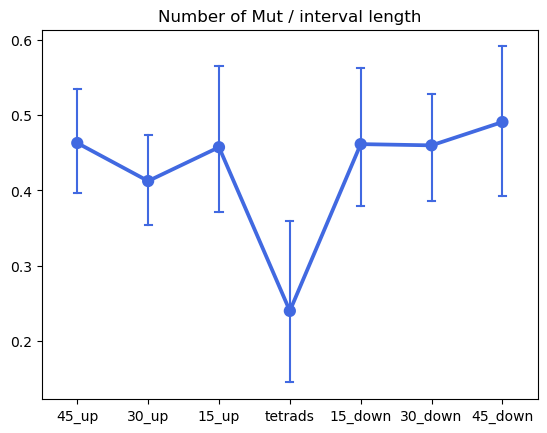

In [32]:
sns.pointplot(data=df_cancer_concat_tetrads, 
                 x=df_cancer_concat_tetrads['side'], y=df_cancer_concat_tetrads['n_mut/length'], 
              color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title='Number of Mut / interval length', xlabel=None, ylabel=None)

[Text(0.5, 1.0, 'Mut ratio, Mut/site'), Text(0.5, 0, ''), Text(0, 0.5, '')]

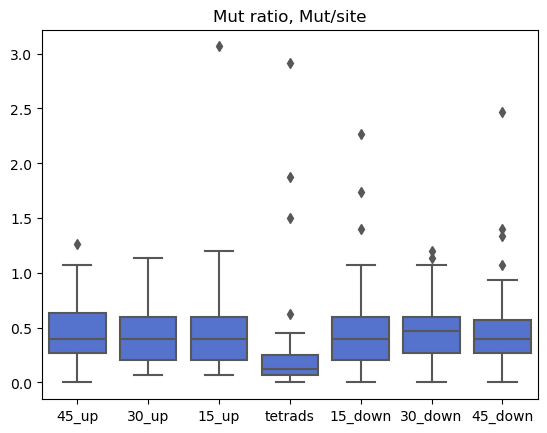

In [28]:
sns.boxplot(data=df_cancer_concat_tetrads, 
                 x=df_cancer_concat_tetrads['side'], y=df_cancer_concat_tetrads['n_mut/length'], 
              color=colors[0], order=order) \
        .set(title='Mut ratio, Mut/site', xlabel=None, ylabel=None)

C:\Users\777\AppData\Local\Temp\ipykernel_2000\286252427.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


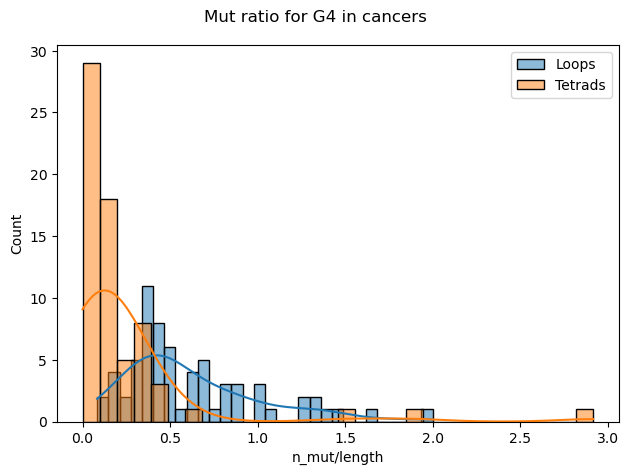

In [62]:
fig, axs = plt.subplots()
sns.histplot(df_cancer_concat[df_cancer_concat['side']=='loops']['n_mut/length'], bins=30, kde=True, label='Loops')
sns.histplot(df_cancer_concat_tetrads[df_cancer_concat_tetrads['side']=='tetrads']['n_mut/length'],bins=30, kde=True, label='Tetrads')
plt.suptitle('Mut ratio for G4 in cancers')
plt.legend()
plt.tight_layout()
fig.show()

In [37]:
df_category_cancers.category.value_counts()

category
Loop        1011
Tetrad       967
Bulges       428
Mismatch      17
Name: count, dtype: int64

In [53]:
df_category_cancers[df_category_cancers.category == 'Loop'].nuc.value_counts()

nuc
A    449
T    268
C    162
G    132
Name: count, dtype: int64

In [31]:
df_category_cancers[(df_category_cancers['category'] == 'Tetrad') & (df_category_cancers['number_of_Mut'] >= 1)].number_of_Mut.sum()

222.0

In [39]:
muts_in_tetrads = df_category_cancers[((df_category_cancers['category'] == 'Tetrad') | \
                                           (df_category_cancers['category'] == 'Mismatch')) & \
                                      (df_category_cancers['number_of_Mut'] > 0)]\
    .melt(['G4_id', 'pos_in_seq', 'pos_in_ref'], 
          ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'G>A', 'G>C', 'G>T', 'T>A', 'T>C', 'T>G'], 'sbs', 'count')

muts_in_tetrads = muts_in_tetrads[muts_in_tetrads['count'] > 0]
muts_in_tetrads

G4_id  pos_in_seq  pos_in_ref  sbs  count
107      59           4       14624  A>C    1.0
112      60          22       14793  A>C    1.0
272      65          16       16175  A>G    2.0
453       4           7         541  C>A    1.0
455       4          10         544  C>A    1.0
...     ...         ...         ...  ...    ...
879      67          12       16365  C>T    7.0
880      67          13       16366  C>T    1.0
1477      3           8         466  T>C    1.0
1488      5          43        1000  T>C    1.0
1536     38           1       10974  T>C    1.0

[156 rows x 5 columns]

In [ ]:
muts_in_tetrads.groupby(['G4_id', ''])

In [50]:
muts_in_tetrads.groupby('sbs')['count'].sum().sort_values(ascending=False)

sbs
C>T    189.0
C>A     27.0
C>G      6.0
T>C      3.0
A>C      2.0
A>G      2.0
Name: count, dtype: float64

Text(0.5, 1.0, '#muts in G4 tetrads')

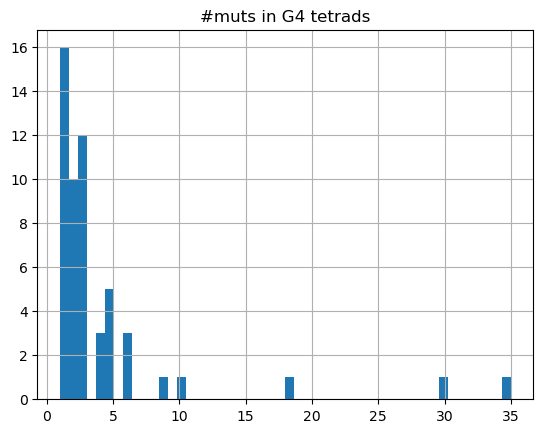

In [45]:
muts_in_tetrads.groupby('G4_id')['count'].sum().hist(bins=50).set_title('#muts in G4 tetrads')

In [43]:
muts_in_tetrads.groupby('G4_id')['count'].sum().sort_index()

G4_id
1      6.0
2      1.0
3      9.0
4     10.0
5      1.0
6      3.0
8      2.0
9      2.0
10     2.0
11     6.0
13     4.0
15     3.0
16     3.0
17     3.0
18     2.0
19     5.0
22     1.0
23     2.0
25     1.0
26     2.0
28     1.0
29     4.0
30     1.0
32     2.0
33     2.0
35     2.0
36     1.0
37     3.0
38     2.0
39     5.0
40     3.0
41     1.0
42     4.0
43     1.0
44     1.0
45     3.0
46     1.0
48     3.0
49     5.0
50     6.0
51     5.0
52     3.0
55     1.0
56     1.0
57     1.0
59     3.0
60     3.0
61     3.0
62     1.0
63     1.0
64     5.0
65    30.0
66    35.0
67    18.0
Name: count, dtype: float64

### Len(intervals) == len(loops)

In [54]:
df_n_col_cancer = pd.read_csv('../data/processed/df_n_col_cancer_pqs.csv')

In [113]:
norm_n_col = add_col_to_norm_mutspec(get_norm_mutspec(df_n_col_cancer).fillna(0), df_n_col_cancer)

In [114]:
norm_n_col['location'] = norm_n_col['side'].str.replace('n_up', '-1').replace('n_down', '1')

In [115]:
norm_n_col['location'] = norm_n_col['location'].astype('int')

In [116]:
norm_n_merged = pd.concat([norm_n_col,norm_loop,norm_tetrads])

In [117]:
norm_n_merged_loops = pd.concat([norm_n_col,norm_loop])

In [118]:
norm_n_merged_tetrads = pd.concat([norm_n_col,norm_tetrads])

In [107]:
# norm_n_merged['side'].isin(['loops', 'tetrads'])

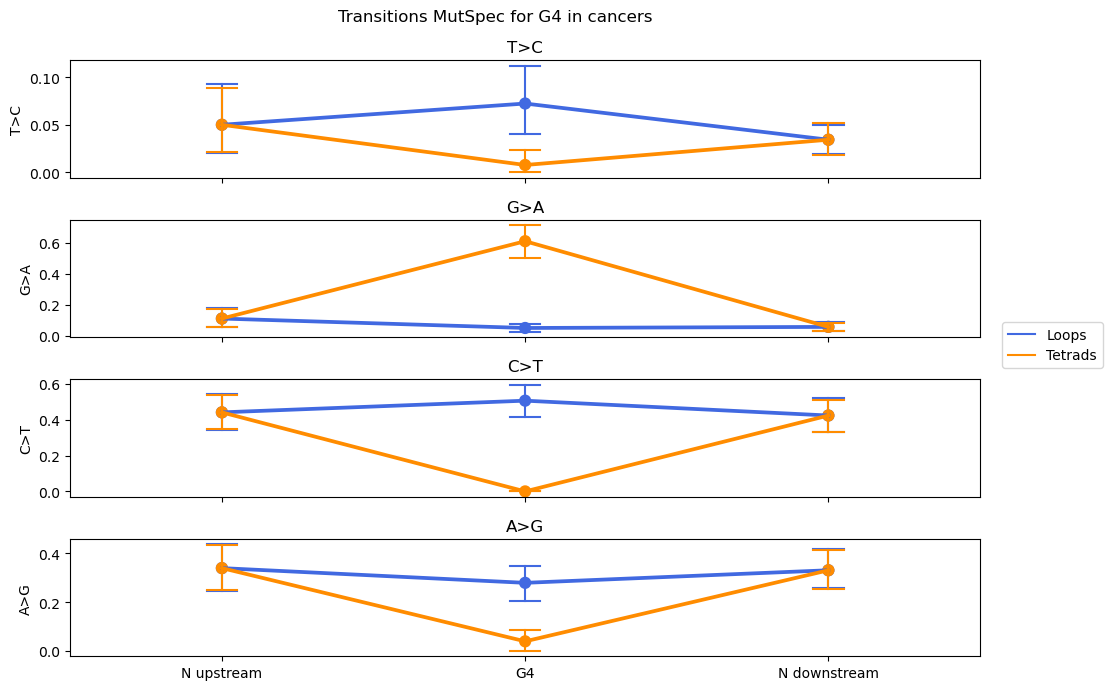

In [127]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-1, 0, 1]

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=norm_n_merged_loops, 
                 x='location', y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_n_merged_tetrads, 
                 x='location', y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']

# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])
plt.suptitle('Transitions MutSpec for G4 in cancers')
plt.tight_layout()
plt.show()

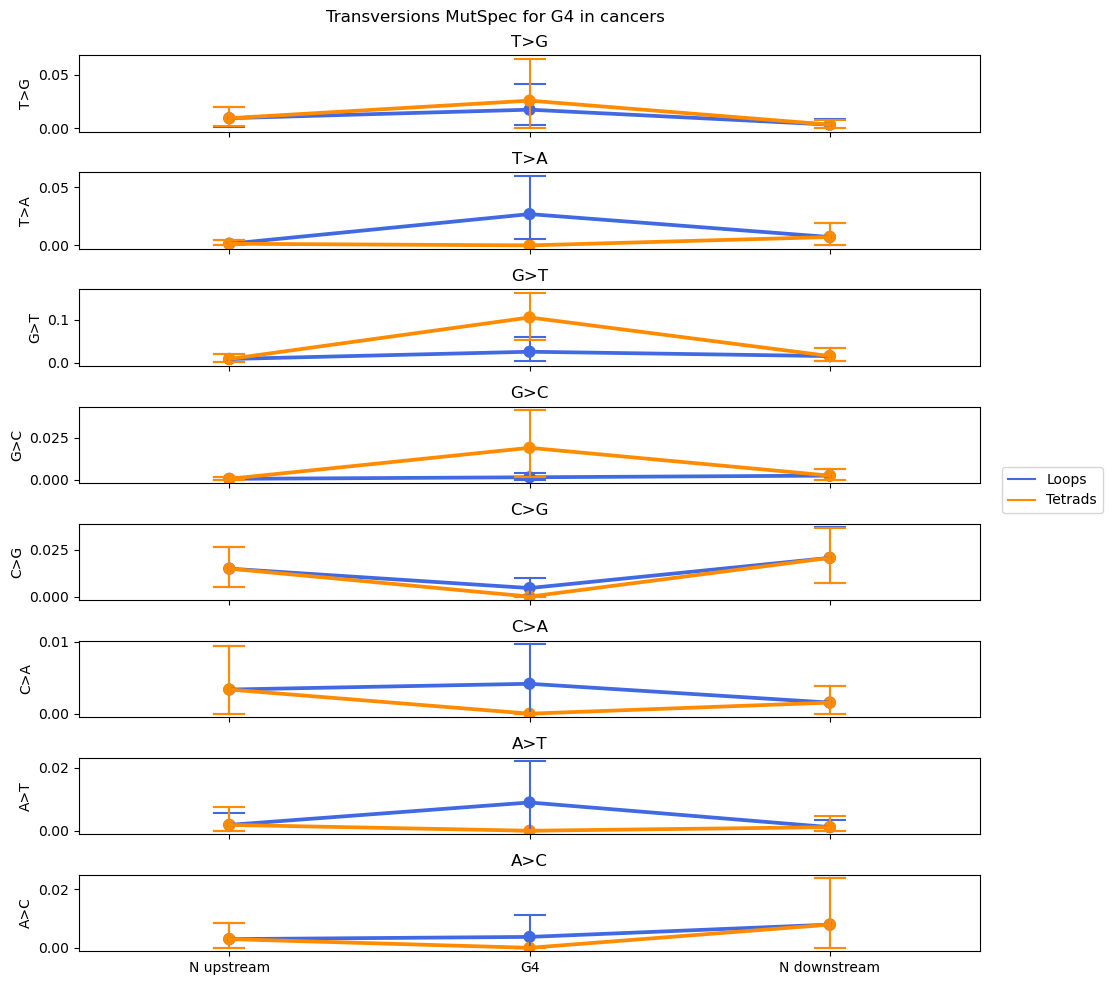

In [128]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = [-1, 0, 1]

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=norm_n_merged_loops, 
                 x='location', y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)
    sns.pointplot(data=norm_n_merged_tetrads, 
                 x='location', y=mutation, ax=axs[row], color=colors[1], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

# Create custom legend handles and labels
handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
labels = ['Loops', 'Tetrads']

# Add legend with custom handles and labels
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])
plt.suptitle('Transversions MutSpec for G4 in cancers')
plt.tight_layout()
plt.show()

In [176]:
# fig, axs = plt.subplots(4, sharex=False,  figsize=(10, 7))
# mutations = ['T>C', 'G>A', 'C>T', 'A>G']

# colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
# order = [-1, 0, 1]

# for i, mutation in enumerate(mutations):
#     row = i % 4
#     sns.histplot(data=norm_n_merged[norm_n_merged['side'] == 'loops'], 
#                  x=mutation, ax=axs[row], color=colors[0], bins=40) \
#         .set(title=mutation, xlabel=None)
#     sns.histplot(data=norm_n_merged[norm_n_merged['side'] == 'tetrads'], 
#                  x=mutation, ax=axs[row], color=colors[1], bins=40) \
#         .set(title=mutation, xlabel=None)
#     sns.histplot(data=norm_n_merged[norm_n_merged['side'] == 'n_up'], 
#                  x=mutation, ax=axs[row], color=colors[2], bins=40) \
#         .set(title=mutation, xlabel=None)
#     sns.histplot(data=norm_n_merged[norm_n_merged['side'] == 'n_down'], 
#                  x=mutation, ax=axs[row], color=colors[3], bins=40) \
#         .set(title=mutation, xlabel=None)

# # Create custom legend handles and labels
# # handles = [plt.Line2D([], [], color=colors[0]), plt.Line2D([], [], color=colors[1])]
# # labels = ['Loops', 'Tetrads']

# # Add legend with custom handles and labels
# # fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# # axs[0].set_xticklabels(['N upstream', 'G4', 'N downstream'])
# plt.suptitle('Transitions MutSpec for G4 in cancers')
# plt.tight_layout()
# plt.show()

In [270]:
norm_loop['T>G']

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
        ...   
62    0.000000
63    0.136143
64    0.020690
65    0.000000
66    0.000000
Name: T>G, Length: 67, dtype: float64

In [272]:
norm_n_col[norm_n_col['side'] == 'n_up']

G4_id  side     T>G       T>C  T>A       G>T       G>C       G>A  \
0       1  n_up  0.0000  0.000000  0.0  0.000000  0.000000  0.000000   
1       2  n_up  0.0000  0.000000  0.0  0.066667  0.000000  0.133333   
2       3  n_up  0.2021  0.000000  0.0  0.000000  0.000000  0.705512   
3       4  n_up  0.0000  0.000000  0.0  0.014815  0.000000  0.029630   
4       5  n_up  0.0000  0.089400  0.0  0.000000  0.000000  0.080460   
..    ...   ...     ...       ...  ...       ...       ...       ...   
58     62  n_up  0.0000  0.000000  0.0  0.000000  0.000000  0.000000   
59     64  n_up  0.0000  0.000000  0.0  0.000000  0.000000  0.000000   
60     65  n_up  0.0000  0.034783  0.0  0.000000  0.026087  0.730435   
61     66  n_up  0.0000  0.200000  0.0  0.050000  0.000000  0.500000   
62     67  n_up  0.0000  0.160000  0.0  0.000000  0.000000  0.700000   

         C>T       C>G       C>A  A>T       A>G  A>C  location  
0   0.000000  0.000000  0.000000  0.0  1.000000  0.0        -1  
1   0.800000  0.000000  0.000000  0.0  0.000000  0.0        -1  
2   0.000000  0.000000  0.000000  0.0  0.092388  0.0        -1  
3   0.266667  0.177778  0.044444  0.0  0.466667  0.0        -1  
4   0.625798  0.089400  0.000000  0.0  0.114943  0.0        -1  
..       ...       ...       ...  ...       ...  ...       ...  
58  0.000000  0.000000  0.000000  0.0  1.000000  0.0        -1  
59  0.727273  0.000000  0.000000  0.0  0.272727  0.0        -1  
60  0.208696  0.000000  0.000000  0.0  0.000000  0.0        -1  
61  0.250000  0.000000  0.000000  0.0  0.000000  0.0        -1  
62  0.000000  0.000000  0.000000  0.0  0.140000  0.0        -1  

[63 rows x 15 columns]

In [275]:
norm_mg = norm_loop.merge(norm_n_col[norm_n_col['side'] == 'n_up'] \
                .rename(columns={c: c+'_n_up' for c in df_n_col_cancer.columns if c not in ['G4_id']}), 
                on='G4_id', how='left')

In [277]:
norm_mg = norm_mg.merge(norm_n_col[norm_n_col['side'] == 'n_down'] \
                .rename(columns={c: c+'_n_down' for c in df_n_col_cancer.columns if c not in ['G4_id']}), 
                on='G4_id', how='left')

In [278]:
norm_mg.columns

Index(['G4_id', 'side', 'T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G',
       'C>A', 'A>T', 'A>G', 'A>C', 'location_x', 'side_n_up', 'T>G_n_up',
       'T>C_n_up', 'T>A_n_up', 'G>T_n_up', 'G>C_n_up', 'G>A_n_up', 'C>T_n_up',
       'C>G_n_up', 'C>A_n_up', 'A>T_n_up', 'A>G_n_up', 'A>C_n_up',
       'location_y', 'side_n_down', 'T>G_n_down', 'T>C_n_down', 'T>A_n_down',
       'G>T_n_down', 'G>C_n_down', 'G>A_n_down', 'C>T_n_down', 'C>G_n_down',
       'C>A_n_down', 'A>T_n_down', 'A>G_n_down', 'A>C_n_down', 'location'],
      dtype='object')

In [282]:
norm_mg = norm_mg.drop(['location_x', 'location_y', 'location', 'side', 'side_n_up', 'side_n_down'], axis=1)

In [284]:
norm_mg['T>G'] - norm_mg['T>G_n_up']

0     0.000000
1     0.000000
2    -0.202100
3     0.000000
4     0.000000
        ...   
62         NaN
63    0.136143
64    0.020690
65    0.000000
66    0.000000
Length: 67, dtype: float64

In [285]:
norm_mg['T>G'] - norm_mg['T>G_n_down']

0     0.000000
1     0.000000
2     0.000000
3    -0.087137
4     0.000000
        ...   
62    0.000000
63    0.136143
64   -0.073060
65    0.000000
66    0.000000
Length: 67, dtype: float64

In [290]:
mutations = ['A>C', 'A>G', 'A>T', 
             'C>A', 'C>G', 'C>T', 
             'G>A', 'G>C', 'G>T', 
             'T>A', 'T>C', 'T>G']

df_diff_loops = pd.DataFrame()

for mut in mutations:
    df_diff_loops[mut+'_diff_up'] = norm_mg[mut] - norm_mg[mut+'_n_up']
    df_diff_loops[mut+'_diff_down'] = norm_mg[mut] - norm_mg[mut+'_n_down']
    df_diff_loops[mut+'_diff_context'] = norm_mg[mut+'_n_up'] - norm_mg[mut+'_n_down']

In [292]:
df_diff_loops = df_diff_loops.fillna(0)

In [293]:
df_diff_loops

A>C_diff_up  A>C_diff_down  A>C_diff_context  A>G_diff_up  A>G_diff_down  \
0           0.0            0.0               0.0    -1.000000      -0.333333   
1           0.0            0.0               0.0     0.000000       0.000000   
2           0.0            0.0               0.0     0.116307      -0.156766   
3           0.0            0.0               0.0    -0.466667       0.000000   
4           0.0            0.0               0.0     0.085057      -0.037288   
..          ...            ...               ...          ...            ...   
62          0.0            0.0               0.0     0.000000       0.071429   
63          0.0            0.0               0.0    -0.078238      -0.574741   
64          0.0            0.0               0.0     0.482759       0.357759   
65          0.0            0.0               0.0     0.101449      -0.152475   
66          0.0            0.0               0.0     0.440645       0.580645   

    A>G_diff_context  A>T_diff_up  A>T_diff_down  A>T_diff_context  \
0           0.666667     0.000000       0.000000               0.0   
1           0.000000     0.000000       0.000000               0.0   
2          -0.273073     0.000000       0.000000               0.0   
3           0.466667     0.000000       0.000000               0.0   
4          -0.122346     0.000000       0.000000               0.0   
..               ...          ...            ...               ...   
62          0.000000     0.000000       0.000000               0.0   
63         -0.496503     0.000000       0.000000               0.0   
64         -0.125000     0.000000       0.000000               0.0   
65         -0.253924     0.000000       0.000000               0.0   
66          0.140000     0.064516       0.064516               0.0   

    C>A_diff_up  ...  G>T_diff_context  T>A_diff_up  T>A_diff_down  \
0      0.000000  ...          0.000000          0.0       0.000000   
1      0.000000  ...          0.066667          1.0       1.000000   
2      0.000000  ...         -0.012048          0.0       0.000000   
3      0.051578  ...         -0.109667          0.0       0.000000   
4      0.000000  ...          0.000000          0.0       0.000000   
..          ...  ...               ...          ...            ...   
62     0.000000  ...          0.000000          0.0       0.000000   
63     0.000000  ...          0.000000          0.0       0.000000   
64     0.000000  ...         -0.500000          0.0       0.000000   
65     0.000000  ...          0.050000          0.0      -0.027701   
66     0.000000  ...          0.000000          0.0       0.000000   

    T>A_diff_context  T>C_diff_up  T>C_diff_down  T>C_diff_context  \
0           0.000000     0.000000       0.000000          0.000000   
1           0.000000     0.000000       0.000000          0.000000   
2           0.000000     0.000000       0.000000          0.000000   
3           0.000000     0.068587       0.068587          0.000000   
4           0.000000    -0.089400       0.000000          0.089400   
..               ...          ...            ...               ...   
62          0.000000     0.000000      -0.142857          0.000000   
63          0.000000     0.034036       0.034036          0.000000   
64          0.000000     0.027286      -0.031681         -0.058967   
65         -0.027701     0.205797       0.378096          0.172299   
66          0.000000    -0.160000      -0.048077          0.111923   

    T>G_diff_up  T>G_diff_down  T>G_diff_context  
0      0.000000       0.000000          0.000000  
1      0.000000       0.000000          0.000000  
2     -0.202100       0.000000          0.202100  
3      0.000000      -0.087137         -0.087137  
4      0.000000       0.000000          0.000000  
..          ...            ...               ...  
62     0.000000       0.000000          0.000000  
63     0.136143       0.136143          0.000000  
64     0.020690      -0.073060         -0.093750  
65     0.0

<Axes: xlabel='A>G_diff_up', ylabel='Count'>

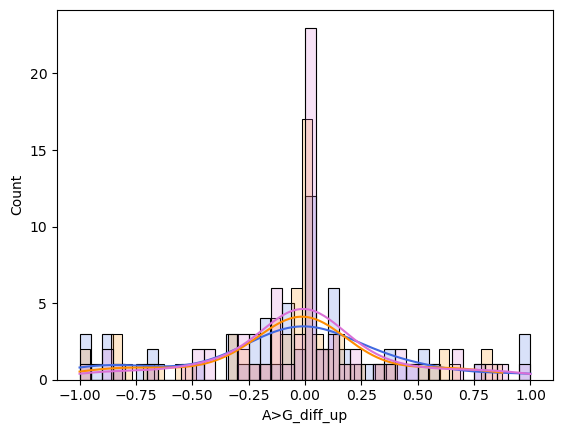

In [312]:
colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
sns.histplot(df_diff_loops['A>G_diff_up'], kde=True, bins=40, alpha=0.2, color=colors[0])
sns.histplot(df_diff_loops['A>G_diff_down'], kde=True, bins=40, alpha=0.2, color=colors[1])
sns.histplot(df_diff_loops['A>G_diff_context'], kde=True, bins=40, alpha=0.2, color=colors[3])

<Axes: xlabel='G>A_diff_up', ylabel='Count'>

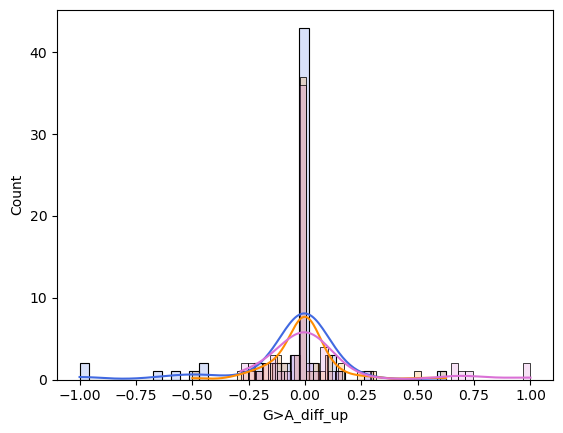

In [313]:
colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
sns.histplot(df_diff_loops['G>A_diff_up'], kde=True, bins=40, alpha=0.2, color=colors[0])
sns.histplot(df_diff_loops['G>A_diff_down'], kde=True, bins=40, alpha=0.2, color=colors[1])
sns.histplot(df_diff_loops['G>A_diff_context'], kde=True, bins=40, alpha=0.2, color=colors[3])

<Axes: xlabel='C>T_diff_up', ylabel='Count'>

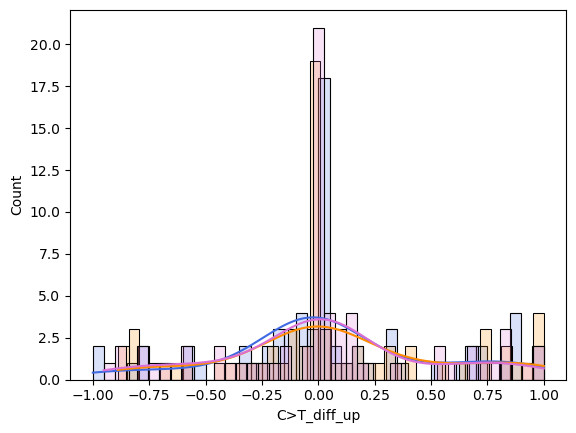

In [314]:
colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
sns.histplot(df_diff_loops['C>T_diff_up'], kde=True, bins=40, alpha=0.2, color=colors[0])
sns.histplot(df_diff_loops['C>T_diff_down'], kde=True, bins=40, alpha=0.2, color=colors[1])
sns.histplot(df_diff_loops['C>T_diff_context'], kde=True, bins=40, alpha=0.2, color=colors[3])

<Axes: xlabel='T>C_diff_up', ylabel='Count'>

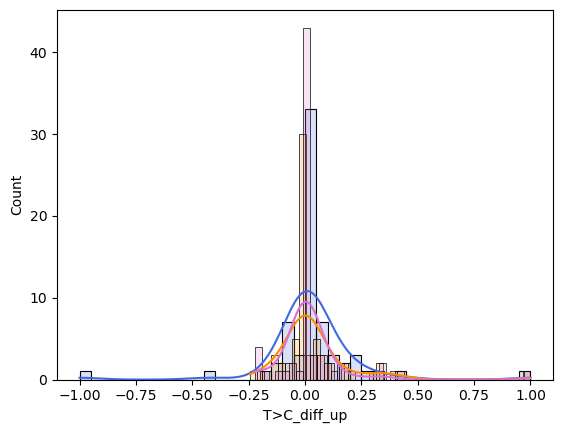

In [315]:
colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
sns.histplot(df_diff_loops['T>C_diff_up'], kde=True, bins=40, alpha=0.2, color=colors[0])
sns.histplot(df_diff_loops['T>C_diff_down'], kde=True, bins=40, alpha=0.2, color=colors[1])
sns.histplot(df_diff_loops['T>C_diff_context'], kde=True, bins=40, alpha=0.2, color=colors[3])

### Make derived table

In [262]:
df_all = g4pqsconf[['G4_id', 'start', 'end', 'sequence']]\
            .rename(columns={c: c+'_g4' for c in g4pqsconf.columns if c not in ['G4_id']}) \
            .merge(
                df_loop_cancer[['G4_id', 'positions', 'sequence', 
                'A', 'C', 'G', 'T', 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C','T>G']] \
                   .rename(columns={c: c+'_loops' for c in df_loop_cancer.columns if c not in ['G4_id']}), 
             on='G4_id', how='left')

In [263]:
df_all = df_all.merge(
                df_tetrads_cancer[['G4_id', 'positions', 'sequence', 
                'A', 'C', 'G', 'T', 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C','T>G']] \
                 .rename(columns={c: c+'_tetrads' for c in df_tetrads_cancer.columns if c not in ['G4_id']}), 
             on='G4_id', how='left')

In [264]:
df_all = df_all.merge(
                df_n_col_cancer[df_n_col_cancer['side'] == 'n_up'][['G4_id', 'window_start', 'window_end', 'sequence', 
                'A', 'C', 'G', 'T', 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C','T>G']] \
                 .reset_index(drop=True) \
                 .rename(columns={c: c+'_n_up' for c in df_n_col_cancer.columns if c not in ['G4_id']}), 
        on='G4_id', how='left')

In [265]:
df_all = df_all.merge(
                df_n_col_cancer[df_n_col_cancer['side'] == 'n_down'][['G4_id', 'window_start', 'window_end', 'sequence', 
                'A', 'C', 'G', 'T', 
                'A>C', 'A>G', 'A>T', 
                'C>A', 'C>G', 'C>T', 
                'G>A', 'G>C', 'G>T', 
                'T>A', 'T>C','T>G']] \
                 .reset_index(drop=True) \
                 .rename(columns={c: c+'_n_down' for c in df_n_col_cancer.columns if c not in ['G4_id']}), 
        on='G4_id', how='left')

In [266]:
df_all = df_all.rename(columns={c: c.lstrip('window_') for c in df_all.columns if c.startswith('win')})

In [267]:
df_all.columns

Index(['G4_id', 'start_g4', 'end_g4', 'sequence_g4', 'positions_loops',
       'sequence_loops', 'A_loops', 'C_loops', 'G_loops', 'T_loops',
       'A>C_loops', 'A>G_loops', 'A>T_loops', 'C>A_loops', 'C>G_loops',
       'C>T_loops', 'G>A_loops', 'G>C_loops', 'G>T_loops', 'T>A_loops',
       'T>C_loops', 'T>G_loops', 'positions_tetrads', 'sequence_tetrads',
       'A_tetrads', 'C_tetrads', 'G_tetrads', 'T_tetrads', 'A>C_tetrads',
       'A>G_tetrads', 'A>T_tetrads', 'C>A_tetrads', 'C>G_tetrads',
       'C>T_tetrads', 'G>A_tetrads', 'G>C_tetrads', 'G>T_tetrads',
       'T>A_tetrads', 'T>C_tetrads', 'T>G_tetrads', 'start_n_up', 'end_n_up',
       'sequence_n_up', 'A_n_up', 'C_n_up', 'G_n_up', 'T_n_up', 'A>C_n_up',
       'A>G_n_up', 'A>T_n_up', 'C>A_n_up', 'C>G_n_up', 'C>T_n_up', 'G>A_n_up',
       'G>C_n_up', 'G>T_n_up', 'T>A_n_up', 'T>C_n_up', 'T>G_n_up',
       'start_n_down', 'end_n_down', 'sequence_n_down', 'A_n_down', 'C_n_down',
       'G_n_down', 'T_n_down', 'A>C_n_down', 'A>G_n_d

In [268]:
df_all

G4_id  start_g4  end_g4  \
0       1       295     315   
1       2       353     387   
2       3       458     506   
3       4       534     571   
4       5       957    1002   
..    ...       ...     ...   
62     63     15526   15556   
63     64     15624   15668   
64     65     16159   16193   
65     66     16260   16296   
66     67     16353   16380   

                                          sequence_g4  \
0                               CCACCAAACCCCCCCTCCCCC   
1                 CCCCAAAAACAAAGAACCCTAACACCAGCCTAACC   
2   CCTCCCACTCCCATACTACTAATCTCATCAATACAACCCCCGCCCATCC   
3              CCCCATACCCCGAACCAACCAAACCCCAAAGACACCCC   
4      CCCCTCCCCAATAAAGCTAAAACTCACCTGAGTTGTAAAAAACTCC   
..                                                ...   
62                    CCCCTTAAACACCCCTCCCCACATCAAGCCC   
63      CCCTATTACTATCCATCCTCATCCTAGCAATAATCCCCATCCTCC   
64                CATAAAAACCCAATCCACATCAAAACCCCCTCCCC   
65              CCCTCACCCACTAGGATACCAACAAACCTACCCACCC   
66                       CCCTTCTCGTCCCCATGGATGACCCCCC   

                                      positions_loops  \
0                                [300, 301, 302, 307]   
1   [357, 358, 359, 360, 361, 372, 373, 374, 379, ...   
2   [464, 470, 471, 472, 473, 474, 475, 476, 477, ...   
3   [538, 539, 540, 545, 546, 547, 548, 549, 550, ...   
4   [961, 966, 967, 968, 969, 970, 971, 972, 973, ...   
..                                                ...   
62  [15530, 15531, 15532, 15533, 15534, 15535, 155...   
63  [15633, 15634, 15635, 15636, 15637, 15638, 156...   
64  [16170, 16171, 16172, 16177, 16178, 16179, 161...   
65  [16263, 16264, 16265, 16269, 16270, 16271, 162...   
66  [16356, 16357, 16358, 16359, 16360, 16361, 163...   

                    sequence_loops  A_loops  C_loops  G_loops  T_loops  ...  \
0                             AAAC        3      1.0      0.0      0.0  ...   
1                       AAAAATAAAG        8      0.0      1.0      1.0  ...   
2       AATACTACTAATCTCATCAATACAAG       12      6.0      1.0      7.0  ...   
3           ATAGAACCAACCAAAAAAGACA       14      5.0      2.0      1.0  ...   
4   TAATAAAGCTAAAACTTGAGTTGTAAAAAA       16      2.0      4.0      8.0  ...   
..                             ...      ...      ...      ...      ...  ...   
62                       TTAAACATA        5      1.0      0.0      3.0  ...   
63             TATCCATTAGCAATAATAT        8      3.0      1.0      7.0  ...   
64                    AATATCAAAACT        7      2.0      0.0      3.0  ...   
65       TCAACTAGGATACCAACAAACCTAA       12      7.0      2.0      4.0  ...   
66                TTCTCGTCATGGATGA        3      3.0      4.0      6.0  ...   

    A>T_n_down  C>A_n_down  C>G_n_down  C>T_n_down  G>A_n_down  G>C_n_down  \
0          0.0         0.0         0.0         0.0         6.0         0.0   
1          0.0         0.0         0.0         0.0         0.0         0.0   
2          0.0         1.0         0.0         4.0         6.0         4.0   
3          0.0         2.0         0.0         1.0         5.0         0.0   
4          0.0         0.0         0.0         0.0         9.0         0.0   
..         ...         ...         ...         ...         ...         ...   
62         0.0         0.0         0.0         0.0         3.0         0.0   
63         0.0         0.0         0.0         1.0         0.0         0.0   
64         0.0         4.0         0.0         0.0         1.0         0.0   
65         1.0         0.0         1.0         7.0         2.0         0.0   
66         0.0         0.0         0.0         0.0        33.0         0.0   

    G>T_n_down  T>A_n_down  T>C_n_down  T>G_n_down  
0          0.0         0.0         3.0         0.0  
1          0.0         0.0         0.0         0.0  
2          1.0         0.0         7.0         0.0  
3          0.0         0.0         0.0         0.0  
4          0.0         0.0         2.0         0.0  
..         ...         ...         ...         ...  
62  

### Sampling

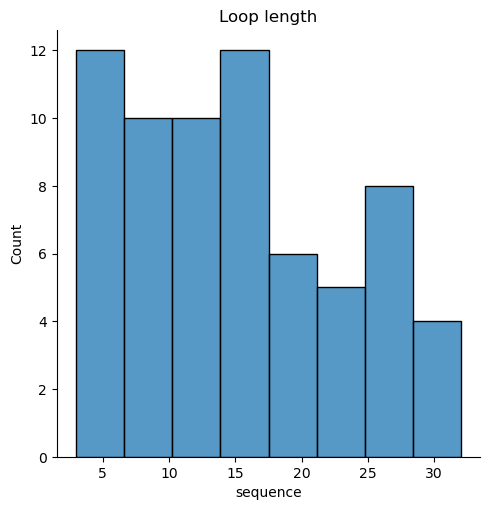

In [24]:
sns.displot(df_loop_cancer['sequence'].apply(lambda x: len(x))).set(title='Loop length')

In [19]:
df_loop_cancer[df_loop_cancer['sequence'].apply(lambda x: len(x)) < 10].shape

(15, 22)

In [20]:
# df_loop_cancer[df_loop_cancer['sequence'].apply(lambda x: len(x)) >= 10][['G4_id', 'side', 'positions']]

In [21]:
def sampling_data(df:pd.DataFrame, sample_size:int, frac:int, mode:str):
    all_sampling_data = []
    if mode == 'loops': 
        for row, G4_id in zip(df['positions'], 
                              df['G4_id']):
            
            for i in range(sample_size):
                sample_loops = []
                l = list(map(int, row.strip('[]').replace(' ', '').split(',')))
                frac = frac
                sample_l = sorted(sample(l, int(len(l) * frac)))
                seq = ''.join(ref_annot[ref_annot['Pos'].isin(sample_l)].Nuc.values)
                
                sample_loops.append(G4_id)
                sample_loops.append('loops')
                sample_loops.append(sample_l)
                sample_loops.append(seq)
                all_sampling_data.append(sample_loops)
    
    elif mode == 'around':
        for start, end, side, G4_id in zip(df['window_start'], 
                                     df['window_end'],
                                     df['side'],
                                     df['G4_id']):
            for i in range(sample_size):
                sample_around = []
                l = [*range(start, end)]
                frac = frac
                sample_l = sorted(sample(l, int(len(l) * frac)))
                seq = ''.join(ref_annot[ref_annot['Pos'].isin(sample_l)].Nuc.values)
                sample_around.append(G4_id)
                sample_around.append(side)
                sample_around.append(sample_l)
                sample_around.append(seq)
                all_sampling_data.append(sample_around)
    
    return all_sampling_data
    

In [22]:
def make_sampling_df(sampling_list):
    df = pd.DataFrame(data=sampling_list, columns = ['G4_id', 'side', 'positions', 'sequence'])
    nuc_count = df['sequence'].apply(lambda x: Counter(x))
    nuc_count = pd.DataFrame.from_records(nuc_count).sort_index(axis=1)
    df = df.join(nuc_count).fillna(0)
    return df

In [23]:
def collect_mut_cancer(df_cancers:pd.DataFrame, df_win:pd.DataFrame, regime:str):
    if regime == '2col':
        Mut_win = []
        for window_start, window_end in zip(df_win['window_start'], df_win['window_end']):
            row = [*range(window_start, window_end)]
            Mut_win.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))
    elif regime == '1col':
        Mut_win = []
        for row in df_win['positions']:
            # Mut_win.append(str(df_cancers[df_cancers['Pos'].isin( \
            #     list(map(int, row.strip('[]').replace(' ', '').split(','))) \
            #                                                     )].Mut.values))
            Mut_win.append(str(df_cancers[df_cancers['Pos'].isin(row)].Mut.values))
            
    elif regime == 'pos':
        Mut_win = []
        for i in df_win['pos_in_ref']:
            Mut_win.append(str(df_cancers[df_cancers['Pos'] == i].Mut.values))
    
    Mut_win_df = pd.DataFrame(Mut_win)
    Mut_win_df[0] = Mut_win_df[0].str.findall("[A-T]>[A-T]")
    obsMutwin = pd.DataFrame.from_records(Mut_win_df[0].apply(lambda x: Counter(x))).fillna(0).sort_index(axis=1)
    df_win_cancer = df_win.join(obsMutwin)
    df_win_cancer['number_of_Mut'] = df_win_cancer[['A>C','A>G','A>T',
                                                    'C>A','C>G','C>T',
                                                'G>A','G>C','G>T',
                                                'T>A','T>C','T>G']].sum(axis=1)
    return df_win_cancer

In [24]:
all_sample_loops = sampling_data(df_loop_cancer[df_loop_cancer['sequence'].apply(lambda x: len(x)) >= 10], 
                                  sample_size=50, frac=0.5, mode='loops')

In [25]:
# pd.DataFrame(data=all_sample_loops)[:52]

In [26]:
df_sample_loops = collect_mut_cancer(df_cancers, make_sampling_df(all_sample_loops), regime='1col')

In [27]:
all_sample_data = sampling_data(df_15_col_cancer[['G4_id', 'side', 'window_start', 'window_end']],
                                sample_size=50, frac=0.5, mode='around')

In [28]:
df_sample_15 = collect_mut_cancer(df_cancers, make_sampling_df(all_sample_data), regime='1col')

In [29]:
df_sample_15[df_sample_15['G4_id'].isin(df_sample_loops['G4_id'].unique())]

G4_id     side                                          positions  \
50         2    15_up                [338, 341, 342, 344, 349, 350, 352]   
51         2    15_up                [339, 341, 343, 345, 346, 348, 352]   
52         2    15_up                [340, 341, 345, 348, 349, 350, 352]   
53         2    15_up                [338, 340, 343, 345, 348, 349, 351]   
54         2    15_up                [338, 339, 340, 341, 346, 349, 351]   
...      ...      ...                                                ...   
17895     67  45_down  [16410, 16412, 16414, 16415, 16416, 16422, 16423]   
17896     67  45_down  [16411, 16412, 16413, 16416, 16420, 16422, 16424]   
17897     67  45_down  [16411, 16413, 16419, 16420, 16421, 16423, 16424]   
17898     67  45_down  [16410, 16413, 16418, 16419, 16420, 16422, 16423]   
17899     67  45_down  [16410, 16412, 16416, 16417, 16422, 16423, 16424]   

      sequence    A    C    G    T  A>C  A>G  ...  C>A  C>G  C>T  G>A  G>C  \
50     CATTCAA  3.0  2.0  0.0  2.0  0.0  0.0  ...  0.0  0.0  2.0  0.0  0.0   
51     AACCTCA  3.0  3.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  2.0  0.0  0.0   
52     CACCCAA  3.0  4.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0   
53     CCCCCCA  1.0  6.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  4.0  0.0  0.0   
54     CACATCA  3.0  3.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  2.0  0.0  0.0   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
17895  CGGAATA  3.0  1.0  2.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
17896  CGTAATT  2.0  1.0  1.0  3.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
17897  CTCAAAT  3.0  2.0  0.0  2.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
17898  CTTCATA  2.0  2.0  0.0  3.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
17899  CGAATAT  3.0  1.0  1.0  2.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

       G>T  T>A  T>C  T>G  number_of_Mut  
50     0.0  0.0  1.0  0.0            3.0  
51     0.0  0.0  0.0  0.0            3.0  
52     0.0  0.0  0.0  0.0            1.0  
53     0.0  0.0  0.0  0.0            5.0  
54     0.0  0.0  0.0  0.0            2.0  
...    ...  ...  ...  ...            ...  
17895  0.0  0.0  0.0  0.0            0.0  
17896  0.0  0.0  0.0  0.0            0.0  
17897  0.0  0.0  0.0  0.0            0.0  
17898  0.0  0.0  0.0  0.0            0.0  
17899  0.0  0.0  0.0  0.0            0.0  

[13750 rows x 21 columns]

In [30]:
df_sample_norm_l = add_col_to_norm_mutspec(get_norm_mutspec(df_sample_loops), df_sample_loops)

In [31]:
df_sample_norm_15 = add_col_to_norm_mutspec(get_norm_mutspec(df_sample_15), df_sample_15)

In [32]:
df_sample_norm_15[df_sample_norm_15['G4_id'] == 2]

G4_id     side  T>G  T>C  T>A       G>T  G>C       G>A  C>T  C>G  C>A  \
50         2    15_up  0.0  0.0  0.0  0.000000  0.0  0.666667  0.0  0.0  0.0   
51         2    15_up  0.0  0.0  0.0  0.333333  0.0  0.666667  0.0  0.0  0.0   
52         2    15_up  0.0  0.0  0.0  1.000000  0.0  0.000000  0.0  0.0  0.0   
53         2    15_up  0.0  0.0  0.0  0.200000  0.0  0.800000  0.0  0.0  0.0   
54         2    15_up  0.0  0.0  0.0  0.000000  0.0  1.000000  0.0  0.0  0.0   
...      ...      ...  ...  ...  ...       ...  ...       ...  ...  ...  ...   
15195      2  45_down  0.0  0.0  0.0  1.000000  0.0  0.000000  0.0  0.0  0.0   
15196      2  45_down  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   
15197      2  45_down  0.0  0.0  0.0  1.000000  0.0  0.000000  0.0  0.0  0.0   
15198      2  45_down  0.0  0.0  0.0  1.000000  0.0  0.000000  0.0  0.0  0.0   
15199      2  45_down  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0   

       A>T       A>G  A>C  
50     0.0  0.333333  0.0  
51     0.0  0.000000  0.0  
52     0.0  0.000000  0.0  
53     0.0  0.000000  0.0  
54     0.0  0.000000  0.0  
...    ...       ...  ...  
15195  0.0  0.000000  0.0  
15196  0.0  0.000000  0.0  
15197  0.0  0.000000  0.0  
15198  0.0  0.000000  0.0  
15199  0.0  0.000000  0.0  

[250 rows x 14 columns]

In [33]:
df_sample_15[df_sample_15['G4_id'] == 2]

G4_id     side                            positions sequence    A    C  \
50         2    15_up  [338, 341, 342, 344, 349, 350, 352]  CATTCAA  3.0  2.0   
51         2    15_up  [339, 341, 343, 345, 346, 348, 352]  AACCTCA  3.0  3.0   
52         2    15_up  [340, 341, 345, 348, 349, 350, 352]  CACCCAA  3.0  4.0   
53         2    15_up  [338, 340, 343, 345, 348, 349, 351]  CCCCCCA  1.0  6.0   
54         2    15_up  [338, 339, 340, 341, 346, 349, 351]  CACATCA  3.0  3.0   
...      ...      ...                                  ...      ...  ...  ...   
15195      2  45_down  [417, 420, 421, 427, 429, 430, 431]  GCTCGTC  0.0  3.0   
15196      2  45_down  [417, 418, 419, 420, 423, 426, 428]  GCACTAA  3.0  2.0   
15197      2  45_down  [421, 422, 424, 426, 428, 430, 431]  TTTAATC  2.0  1.0   
15198      2  45_down  [420, 421, 422, 424, 427, 428, 431]  CTTTCAC  1.0  3.0   
15199      2  45_down  [417, 419, 421, 423, 424, 426, 428]  GATTTAA  3.0  0.0   

         G    T  A>C  A>G  ...  C>A  C>G  C>T  G>A  G>C  G>T  T>A  T>C  T>G  \
50     0.0  2.0  0.0  0.0  ...  0.0  0.0  2.0  0.0  0.0  0.0  0.0  1.0  0.0   
51     0.0  1.0  0.0  0.0  ...  1.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
52     0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
53     0.0  0.0  0.0  0.0  ...  1.0  0.0  4.0  0.0  0.0  0.0  0.0  0.0  0.0   
54     0.0  1.0  0.0  0.0  ...  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
15195  2.0  2.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15196  1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15197  0.0  4.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15198  0.0  3.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
15199  1.0  3.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       number_of_Mut  
50               3.0  
51               3.0  
52               1.0  
53               5.0  
54               2.0  
...              ...  
15195            1.0  
15196            0.0  
15197            1.0  
15198            1.0  
15199            0.0  

[250 rows x 21 columns]

In [34]:
df_sample_norm_concat = pd.concat([df_sample_norm_l, 
                                   df_sample_norm_15[df_sample_norm_15['G4_id'].isin(df_sample_norm_l['G4_id'].unique())]]) \
    .reset_index(drop=True)

In [35]:
df_sample_norm_concat.columns

Index(['G4_id', 'side', 'T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G',
       'C>A', 'A>T', 'A>G', 'A>C'],
      dtype='object')

In [36]:
df_sample_norm_concat

G4_id     side  T>G  T>C  T>A  G>T  G>C  G>A  C>T  C>G  C>A  A>T  A>G  \
0          2    loops  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1          2    loops  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2          2    loops  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3          2    loops  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4          2    loops  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...      ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
16345     67  45_down  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16346     67  45_down  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16347     67  45_down  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16348     67  45_down  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
16349     67  45_down  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       A>C  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
...    ...  
16345  0.0  
16346  0.0  
16347  0.0  
16348  0.0  
16349  0.0  

[16350 rows x 14 columns]

In [37]:
mutations = ['T>G', 'T>C', 'T>A', 'G>T', 'G>C', 'G>A', 'C>T', 'C>G',
       'C>A', 'A>T', 'A>G', 'A>C']

In [38]:
df_sample_norm_concat['side'].nunique() * df_sample_norm_concat['G4_id'].nunique() * len(mutations)

4368

In [39]:
dct = {}
for G4_id in df_sample_norm_concat['G4_id'].unique():
    for side in df_sample_norm_concat['side'].unique():
        for mut in mutations:
            dct[f"sample_{G4_id}_{side}_{mut}"] = df_sample_norm_concat[(df_sample_norm_concat['G4_id'] == G4_id) & 
                                                                        (df_sample_norm_concat['side'] == side)][mut]

In [40]:
# for G4_id in df_sample_norm_concat['G4_id'].unique():
#     for mut in mutations:
#         print(G4_id, mut, '\n', stats.kruskal(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_up_{mut}"], dct[f"sample_{G4_id}_15_down_{mut}"], dct[f"sample_{G4_id}_30_up_{mut}"], dct[f"sample_{G4_id}_30_down_{mut}"], dct[f"sample_{G4_id}_45_up_{mut}"],dct[f"sample_{G4_id}_45_down_{mut}"])[1])

In [41]:
df_sample_norm_concat['G4_id'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 15, 16, 18, 20, 21, 22, 25, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66,
       67], dtype=int64)

In [42]:
df_mu_15 = []
for G4_id in df_sample_norm_concat['G4_id'].unique():
    
    for mut in mutations:
        a_up = []
        a_down = []
        if (dct[f"sample_{G4_id}_15_up_{mut}"].empty == True) | (dct[f"sample_{G4_id}_15_down_{mut}"].empty == True):
            break
        else:
            # print(G4_id, mut, '\n',
            #   'loop+15up', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_up_{mut}"])[1], '\n', \
            #   'loop+15down', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_down_{mut}"])[1], '\n')
            a_up += G4_id, mut, \
            'loop+15up', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_up_{mut}"])[1]
            a_down += G4_id, mut, \
            'loop+15down', stats.mannwhitneyu(dct[f"sample_{G4_id}_loops_{mut}"], dct[f"sample_{G4_id}_15_down_{mut}"])[1]
            
            df_mu_15.append(a_up)
            df_mu_15.append(a_down)

In [44]:
df_mu_15 = pd.DataFrame(df_mu_15, columns=['G4_id', 'mut', 'side', 'p_val'])

In [52]:
df_mu_15.head()

G4_id  mut         side         p_val
0      2  T>G    loop+15up  1.000000e+00
1      2  T>G  loop+15down  1.000000e+00
2      2  T>C    loop+15up  1.000000e+00
3      2  T>C  loop+15down  1.000000e+00
4      2  T>A    loop+15up  7.546196e-11

In [45]:
df_mu_15.G4_id.nunique()

49

In [46]:
mut_per_id = df_mu_15[df_mu_15['p_val'] < 0.05].groupby('G4_id').agg({'mut': 'value_counts'}).rename(columns={'mut':'count'})

In [55]:
mut_per_id.head()

count
G4_id mut       
2     T>A      2
      G>A      1
      G>T      1
      C>T      1
      A>G      1

In [47]:
mut_per_id[mut_per_id['count'] > 1].reset_index().G4_id.value_counts()

G4_id
65    5
43    5
36    4
15    4
64    4
61    4
50    4
28    4
67    4
16    3
18    3
40    3
37    3
49    3
51    3
52    3
54    3
45    3
59    3
22    3
57    2
7     2
4     2
46    2
66    2
55    2
9     2
42    2
38    2
3     2
34    2
31    2
11    2
25    2
21    2
20    2
8     1
35    1
30    1
29    1
60    1
6     1
2     1
Name: count, dtype: int64

In [48]:
mut_per_id[mut_per_id['count'] > 1].reset_index().mut.value_counts()

mut
T>C    26
C>T    23
A>G    22
T>A    11
G>A     9
T>G     7
G>T     3
C>G     3
C>A     2
A>T     2
A>C     1
G>C     1
Name: count, dtype: int64

In [49]:
# на семплированных данных
# только у половины Г4 (55% (27, всего 49шт)) C>T значимо отличается от окружения +-15bp

In [50]:
mut_per_id.reset_index().mut.value_counts()

mut
C>T    47
A>G    43
T>C    39
G>A    30
T>A    13
C>G    13
T>G    12
G>T    10
A>C     6
C>A     4
A>T     4
G>C     4
Name: count, dtype: int64

In [51]:
# на семплированных данных
# у большей части Г4 (96% (47, всего 49шт)) C>T значимо отличается хотя бы с одной стороны окружения +-15bp

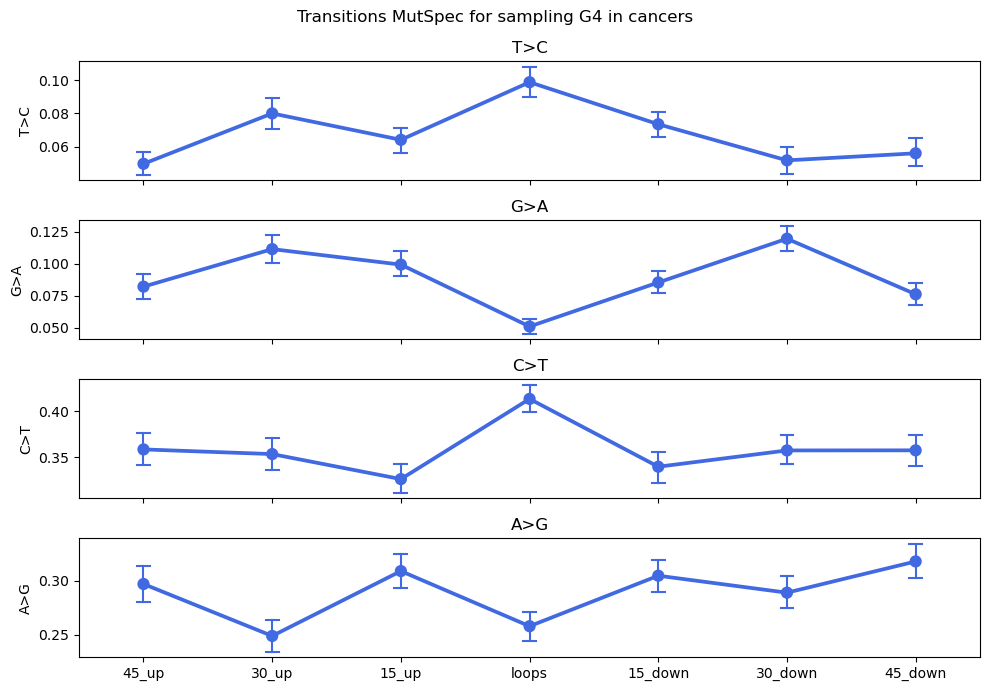

In [56]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=df_sample_norm_concat, 
                 x=df_sample_norm_concat['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)


plt.suptitle('Transitions MutSpec for sampling G4 in cancers')
plt.tight_layout()
plt.show()

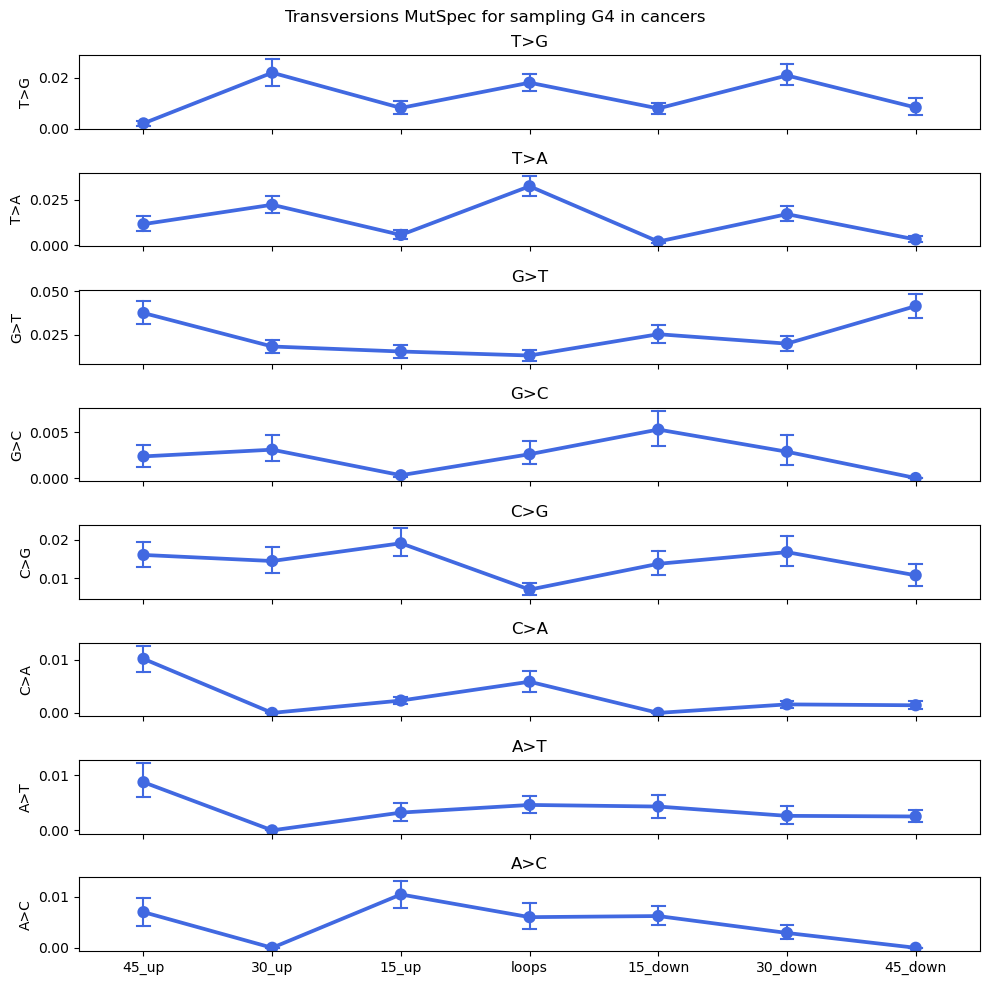

In [63]:
fig, axs = plt.subplots(8, sharex=True, figsize=(10, 10))
mutations = ['T>G', 'T>A', 'G>T', 'G>C', 'C>G', 'C>A', 'A>T', 'A>C']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 8
    sns.pointplot(data=df_sample_norm_concat, 
                 x=df_sample_norm_concat['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)

plt.suptitle('Transversions MutSpec for sampling G4 in cancers')
plt.tight_layout()
plt.show()

#### Transitions for each G4, sampling data

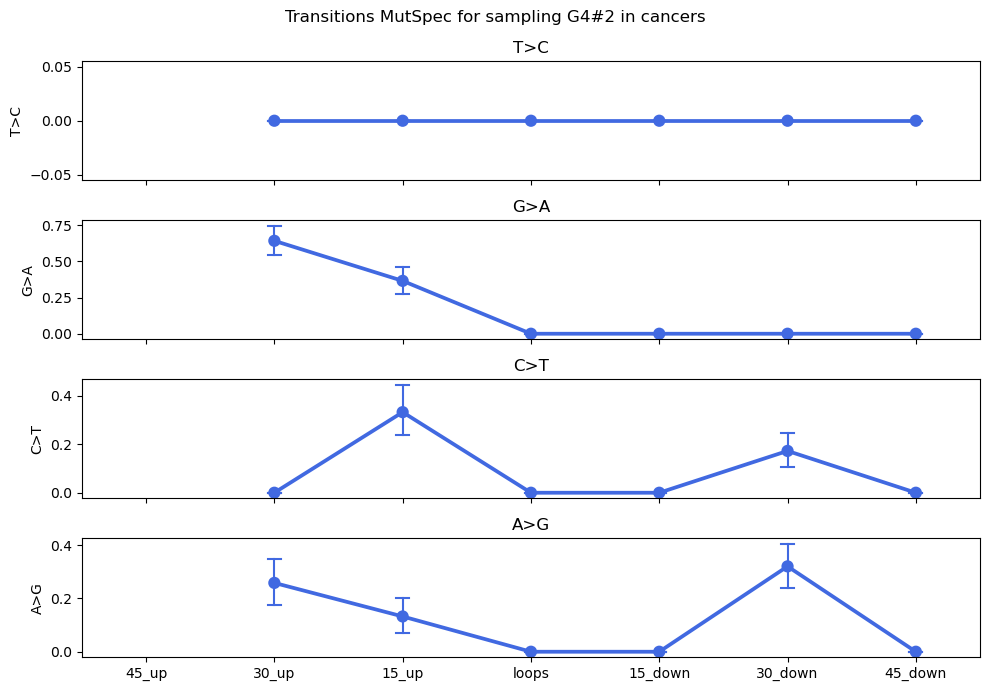

In [58]:
fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
mutations = ['T>C', 'G>A', 'C>T', 'A>G']

colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']

for i, mutation in enumerate(mutations):
    row = i % 4
    sns.pointplot(data=df_sample_norm_concat[df_sample_norm_concat['G4_id']==2], 
                 x=df_sample_norm_concat[df_sample_norm_concat['G4_id']==2]['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
        .set(title=mutation, xlabel=None)


plt.suptitle('Transitions MutSpec for sampling G4#2 in cancers')
plt.tight_layout()
plt.show()

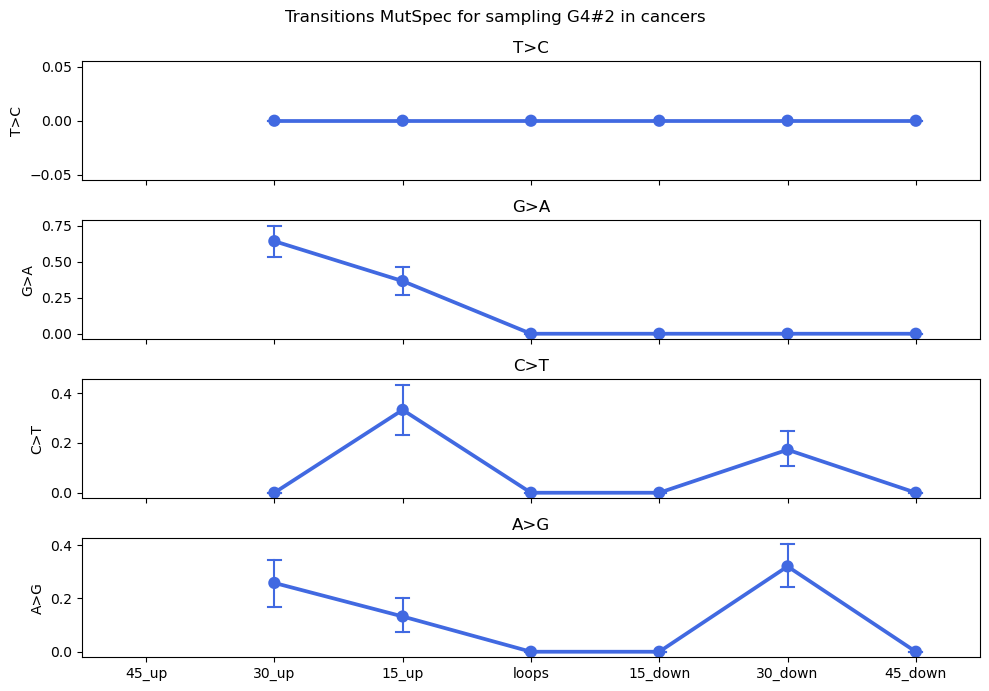

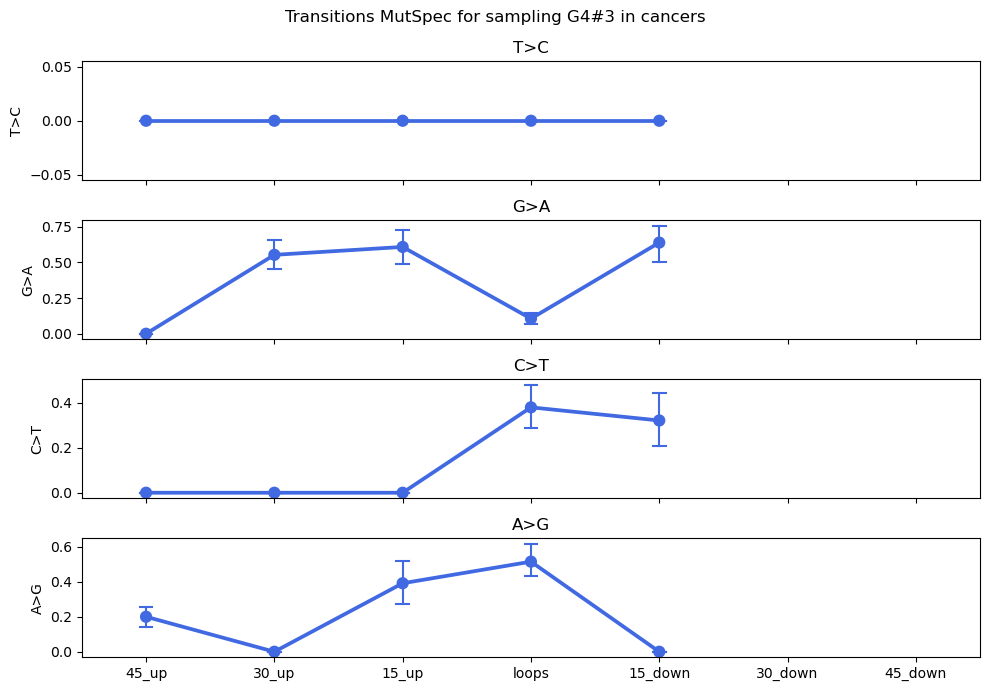

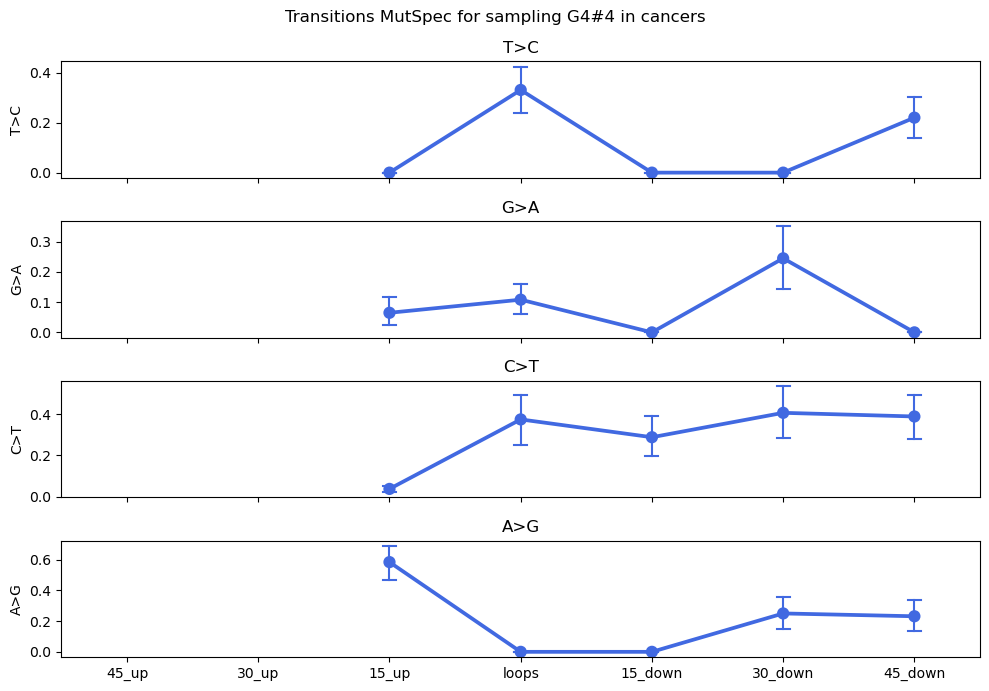

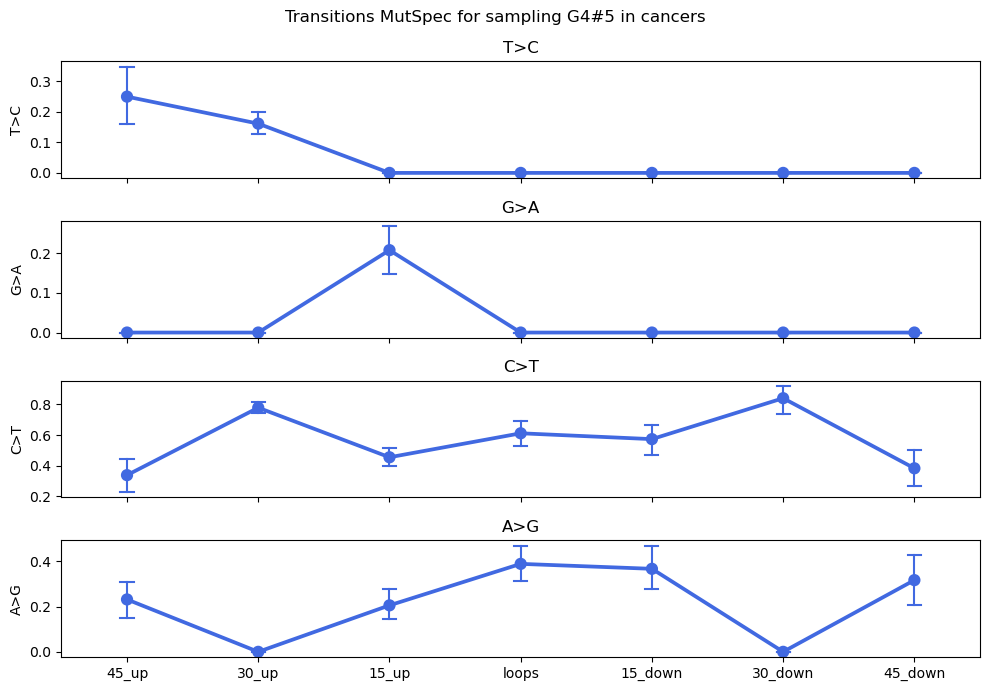

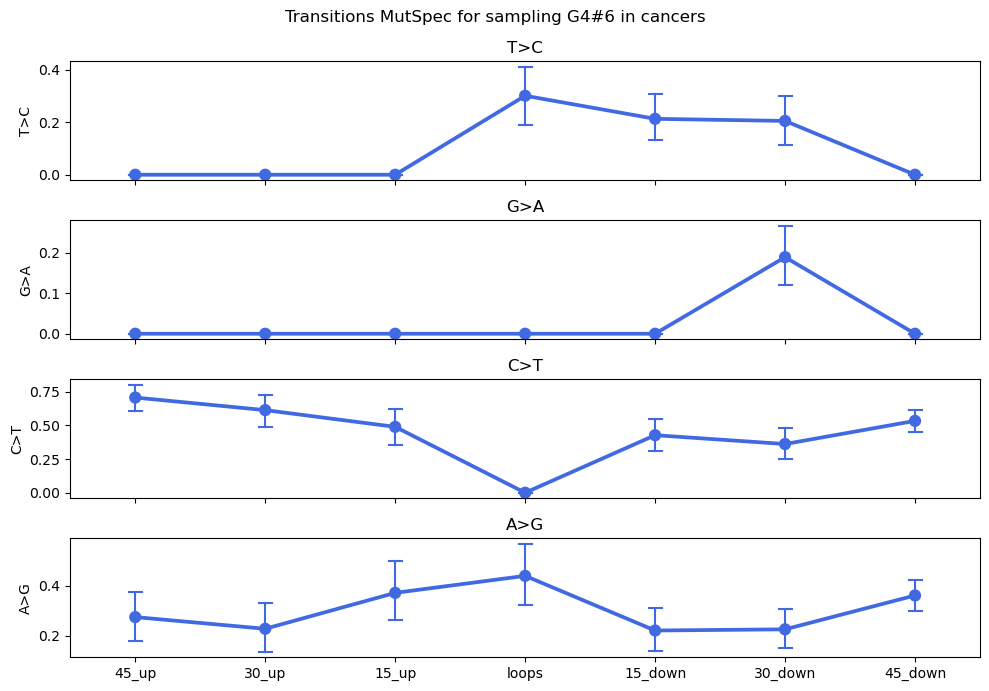

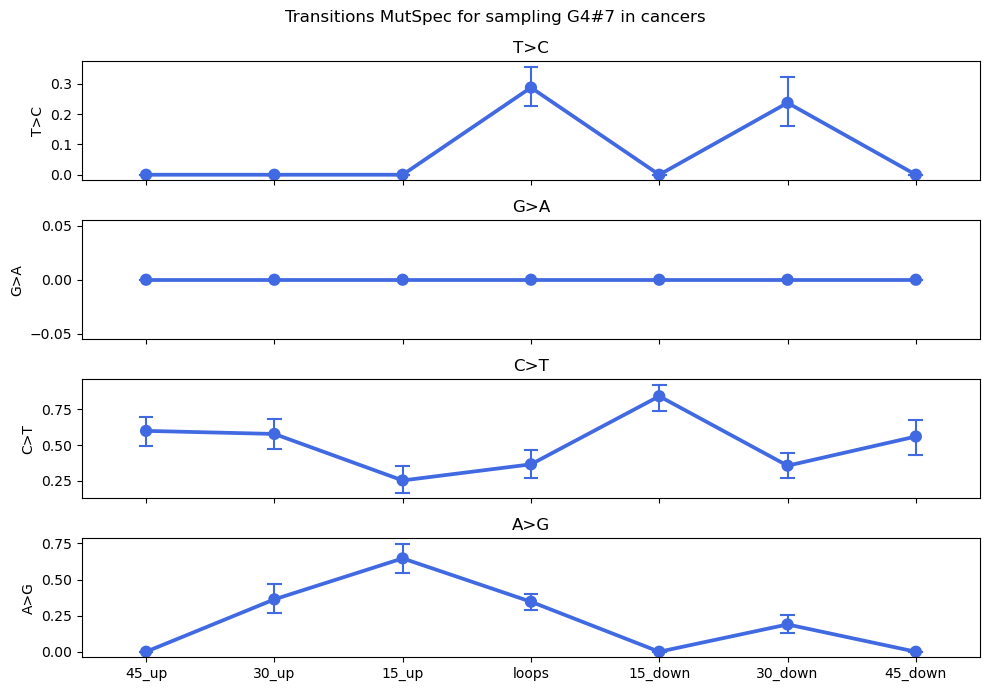

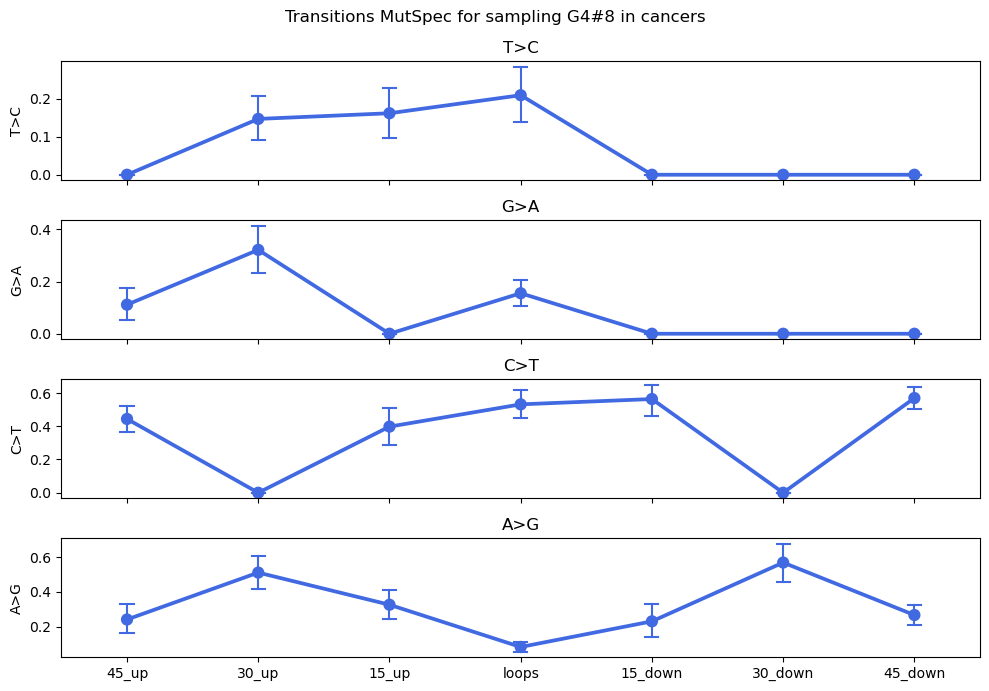

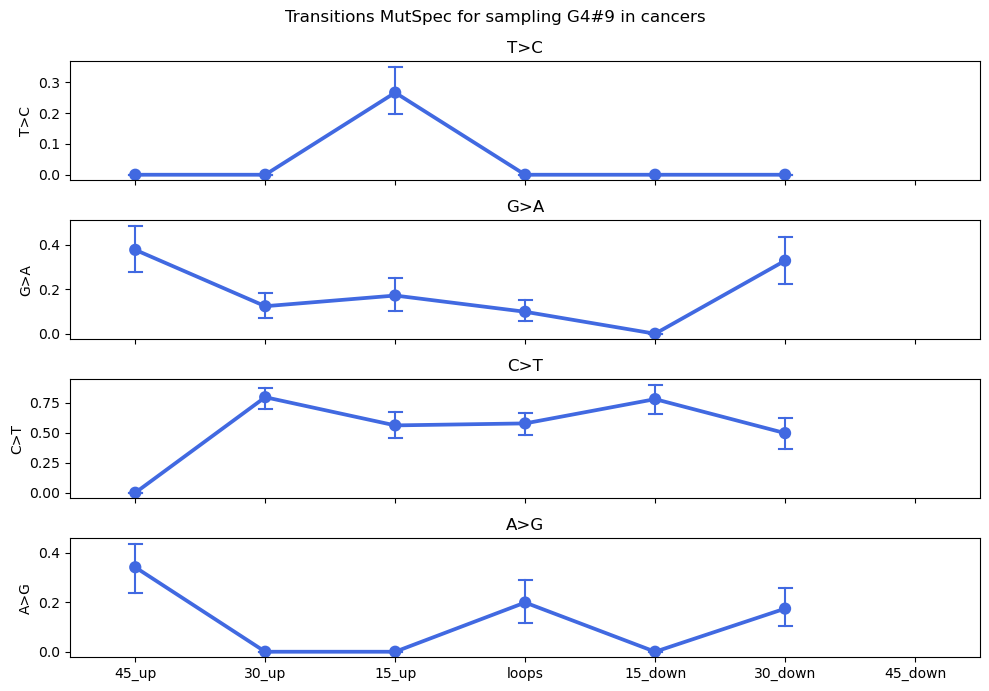

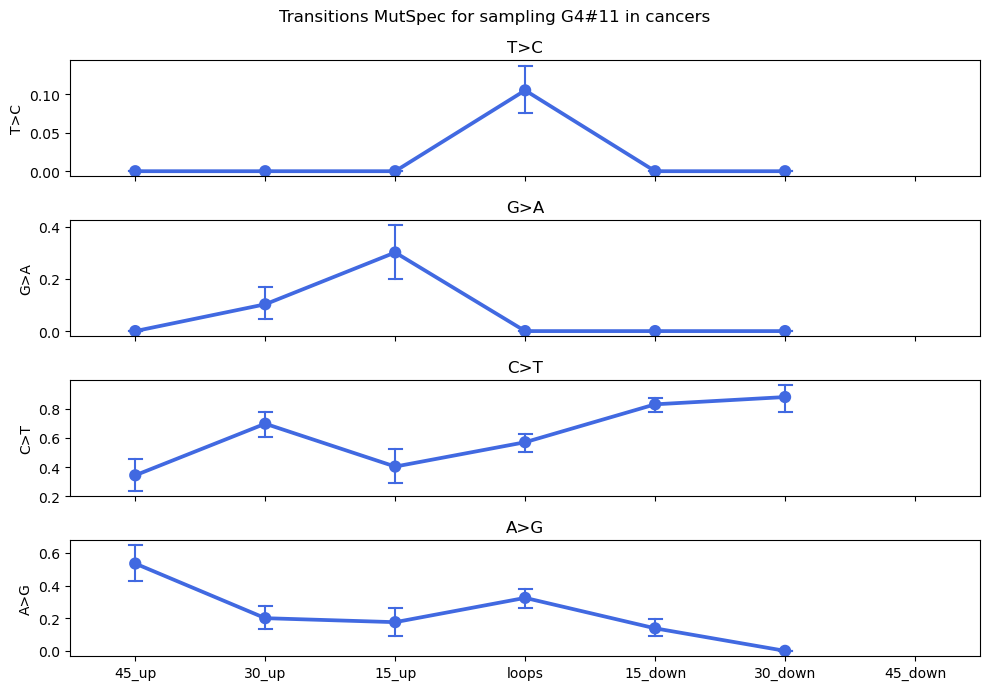

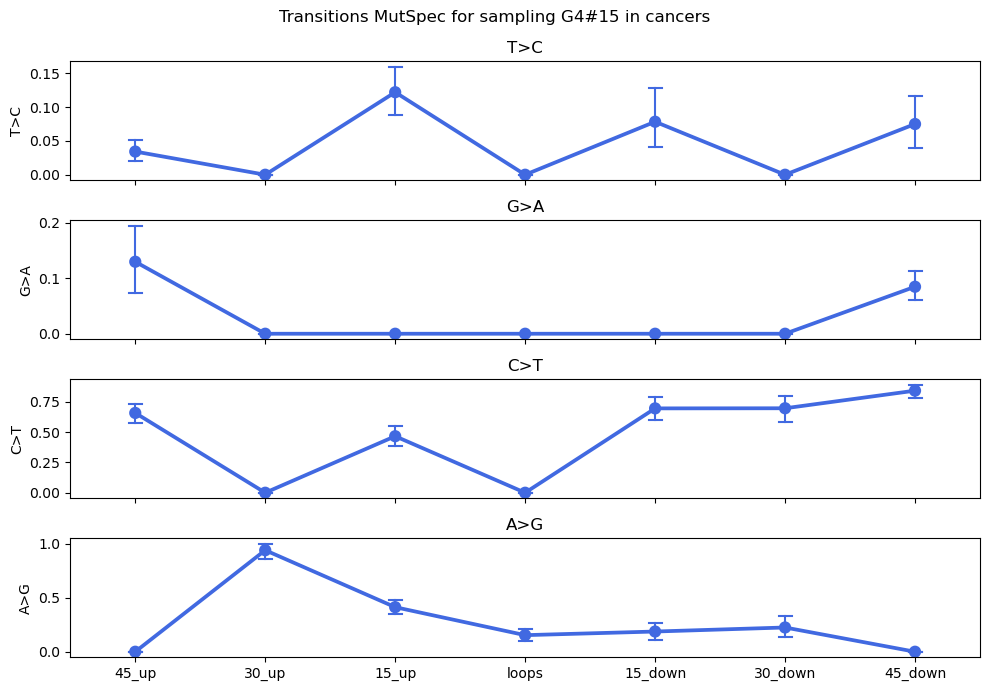

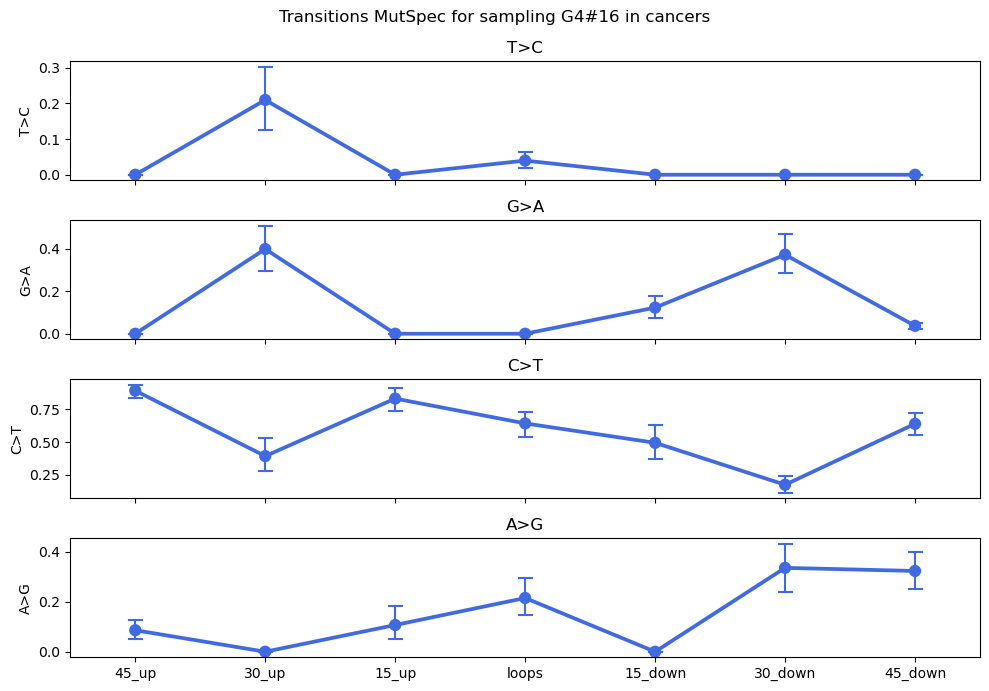

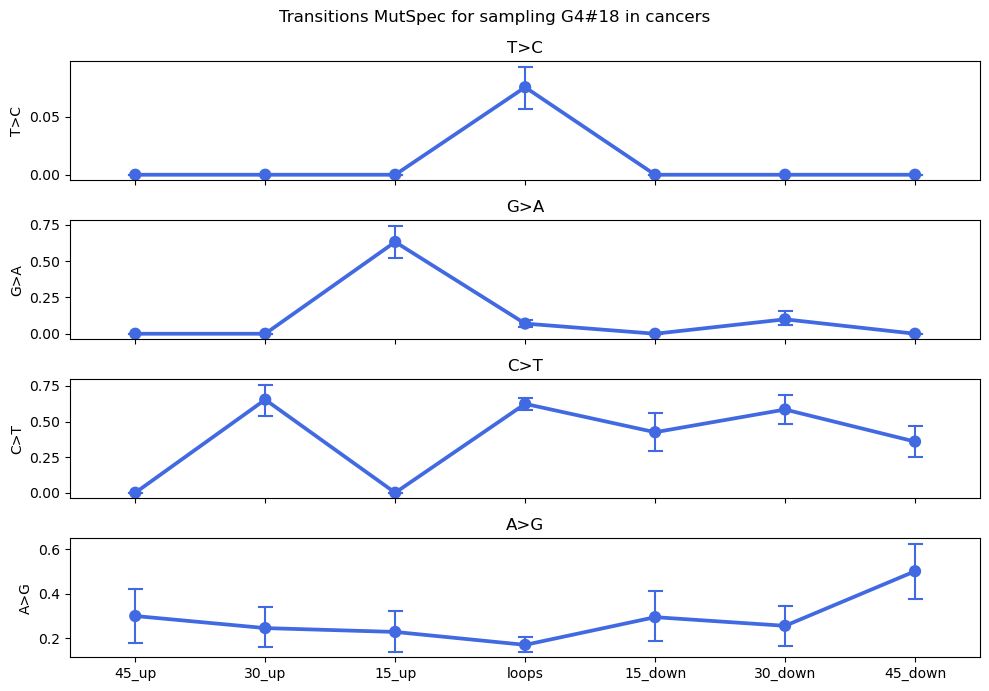

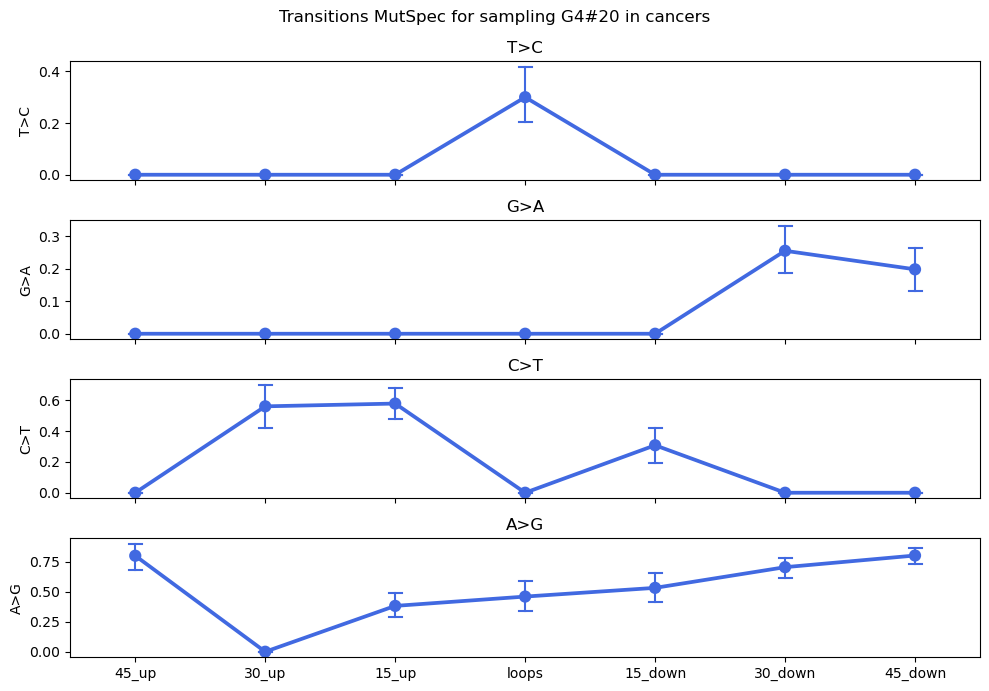

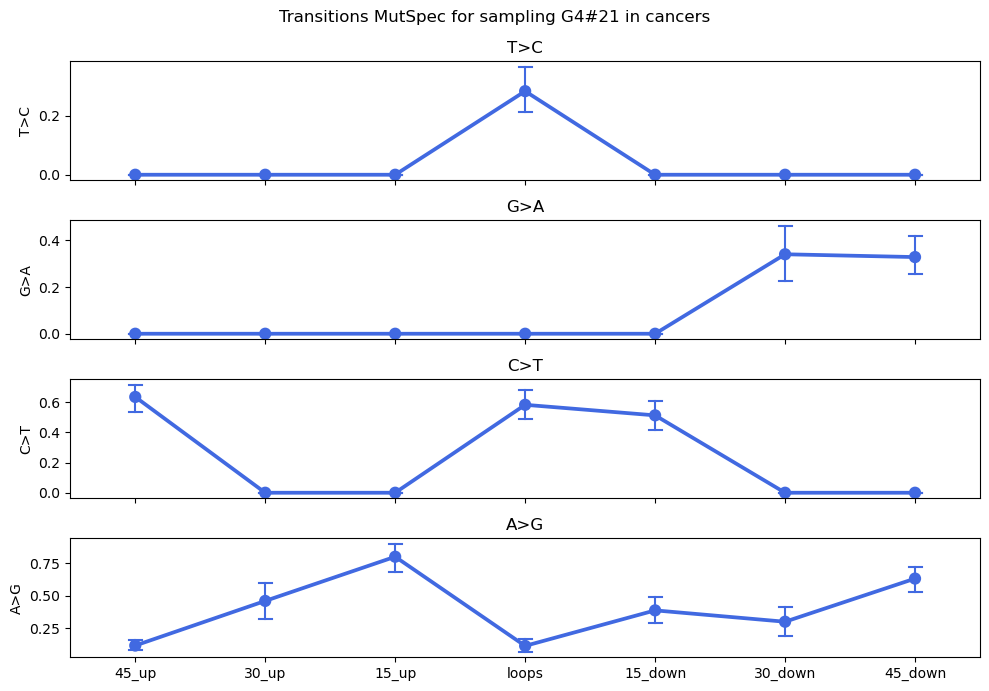

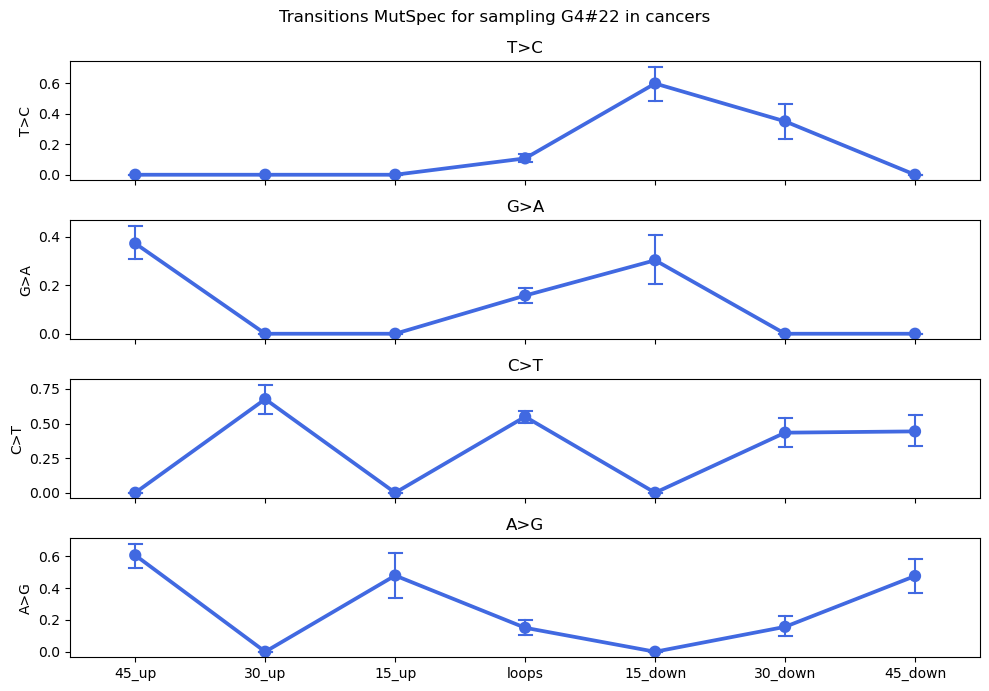

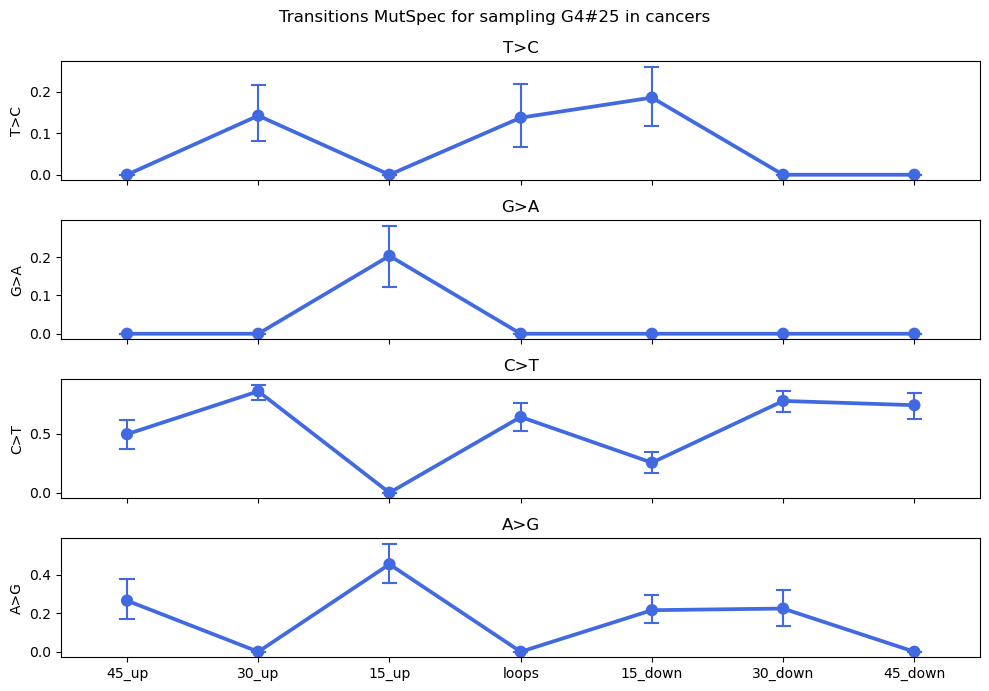

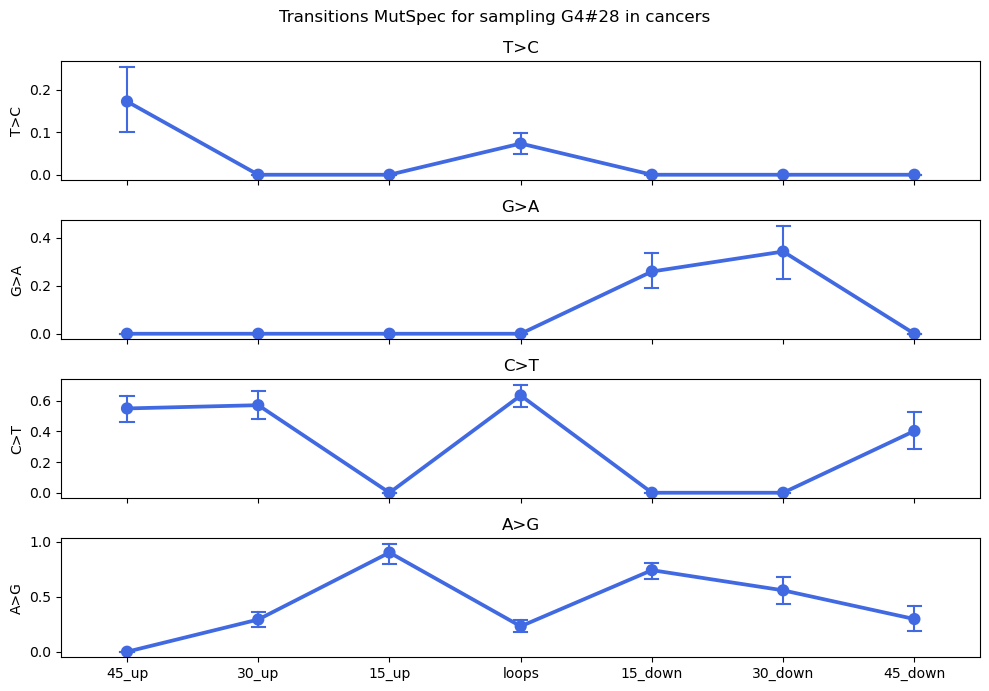

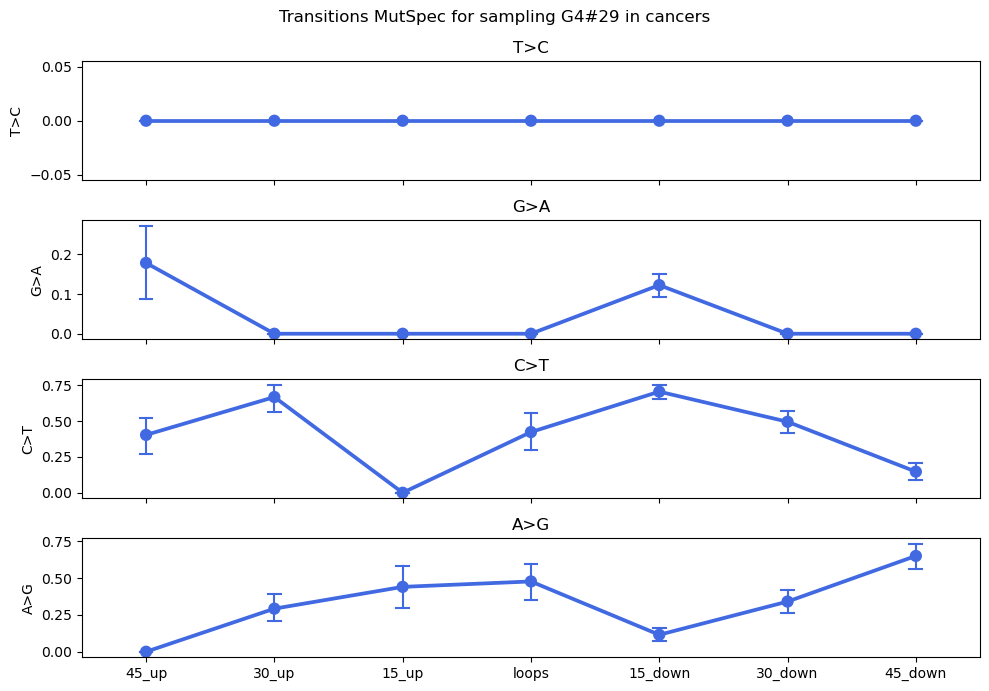

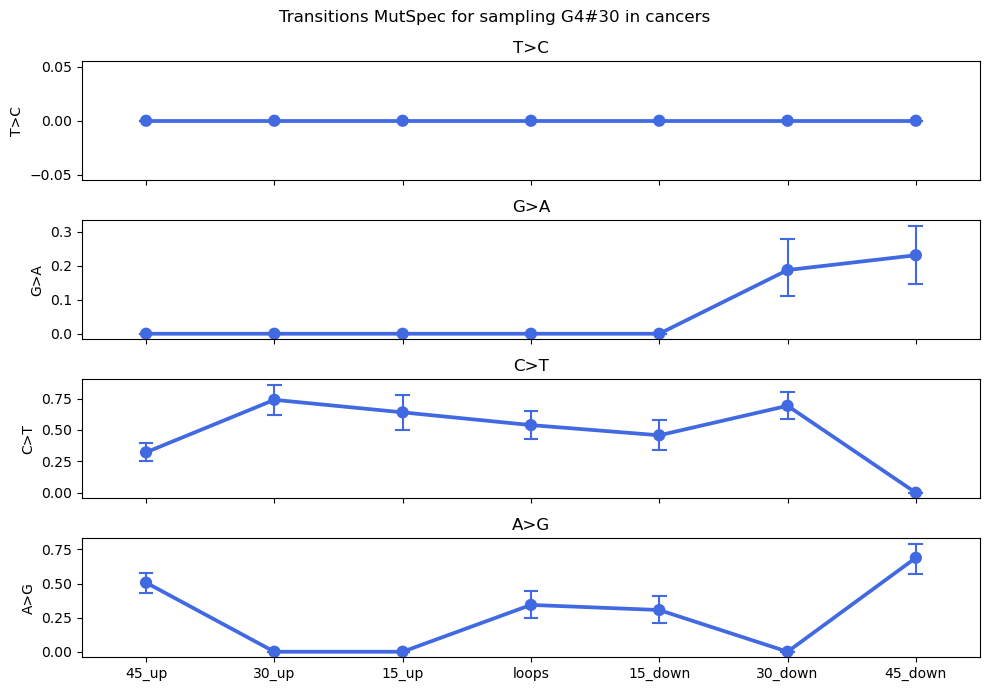

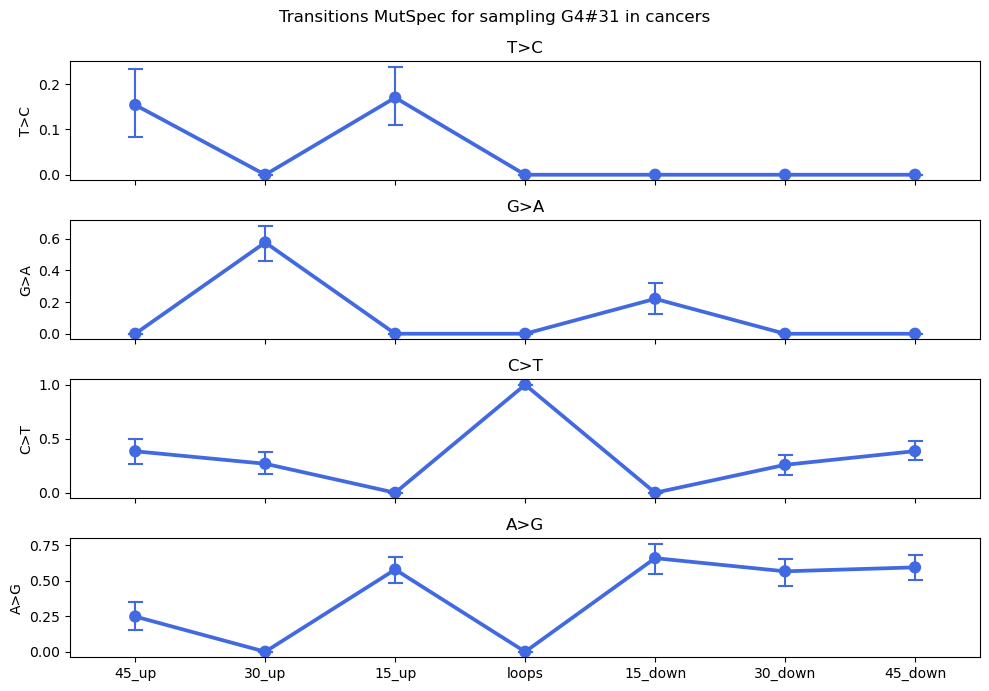

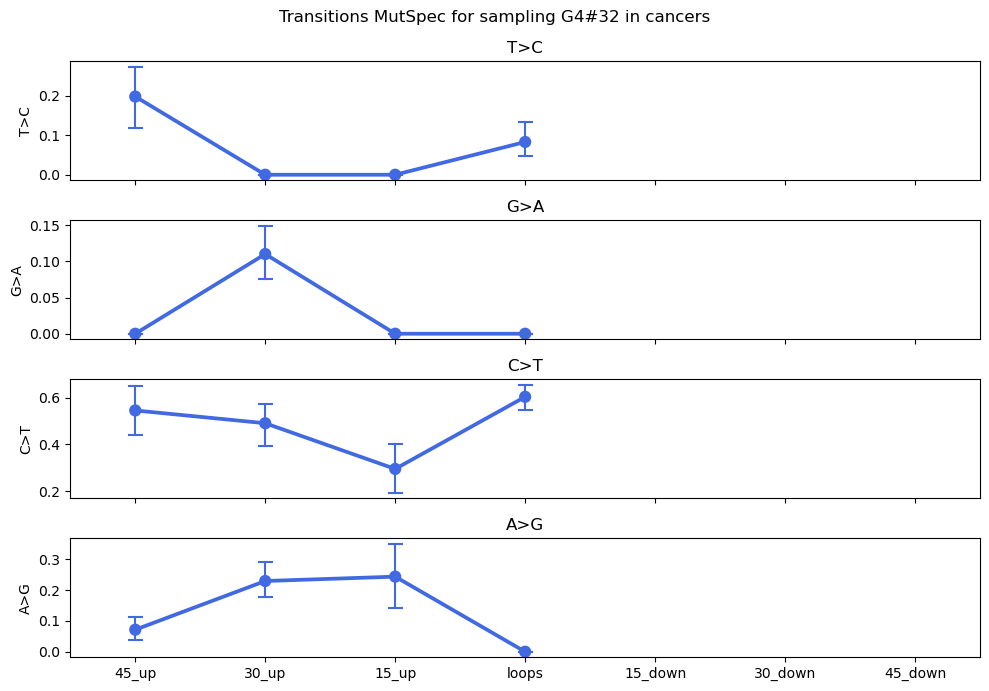

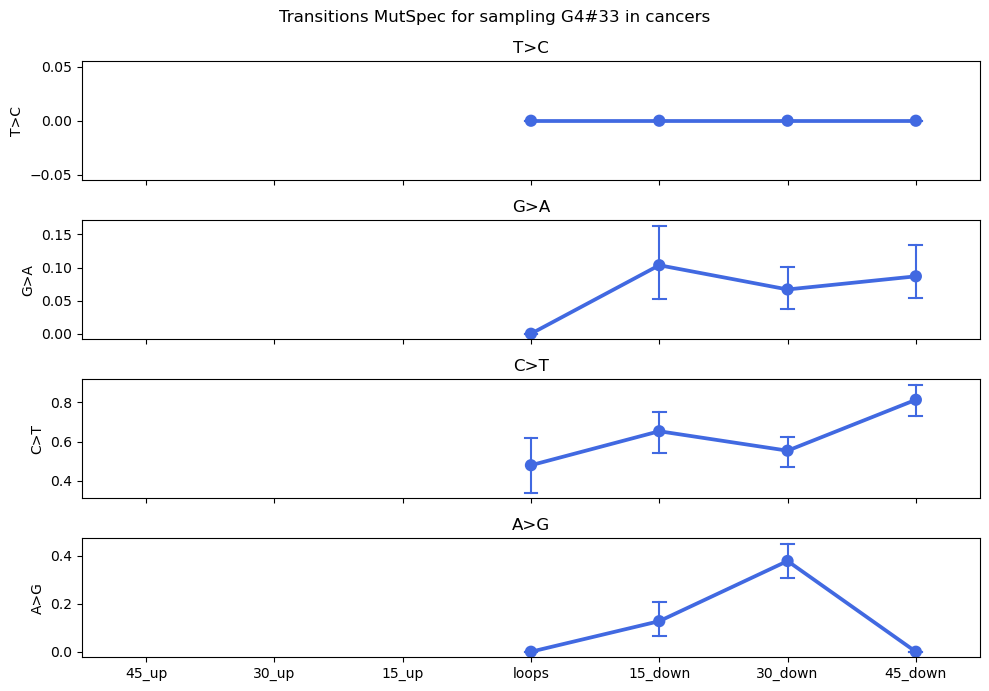

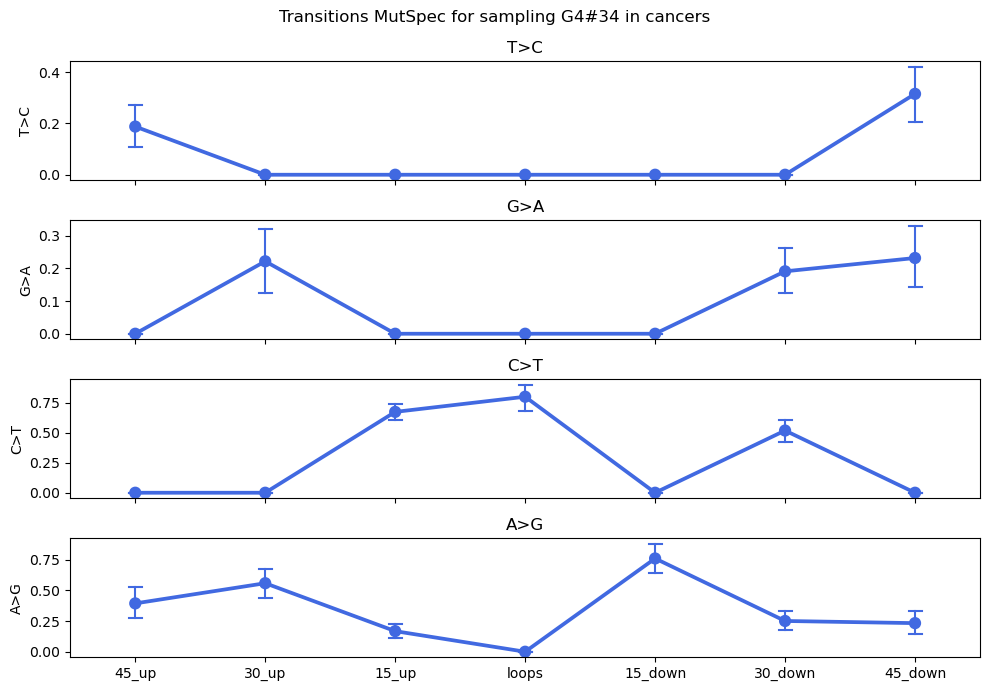

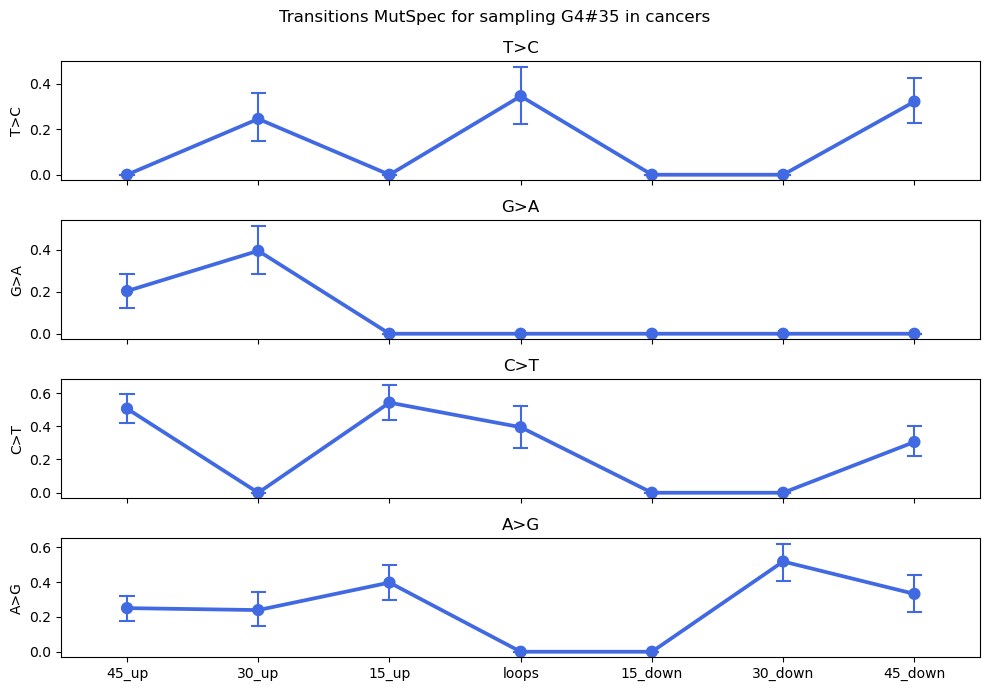

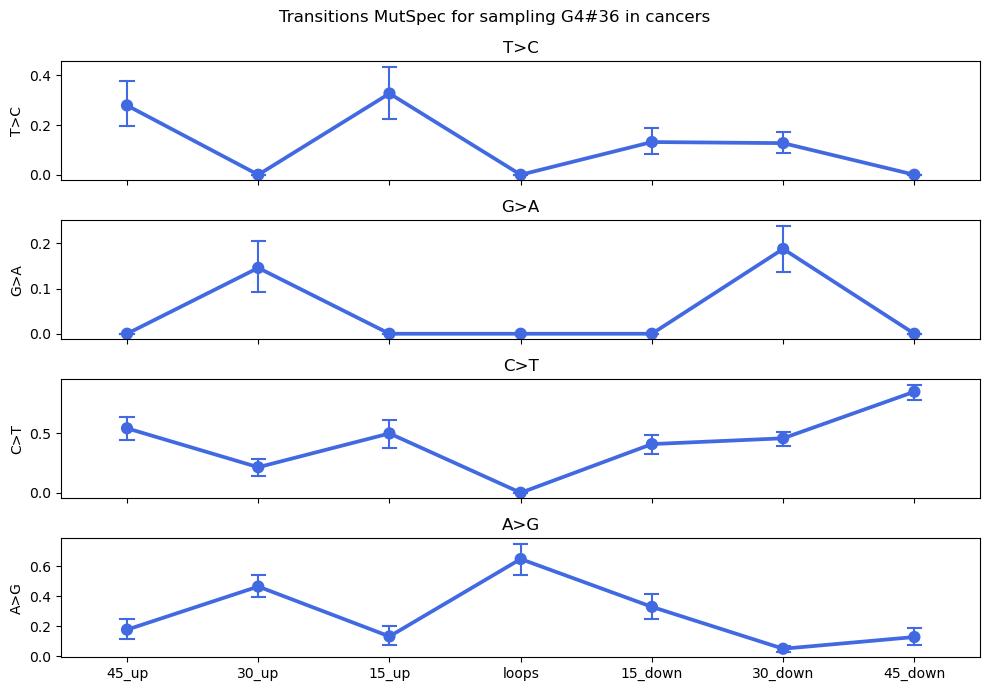

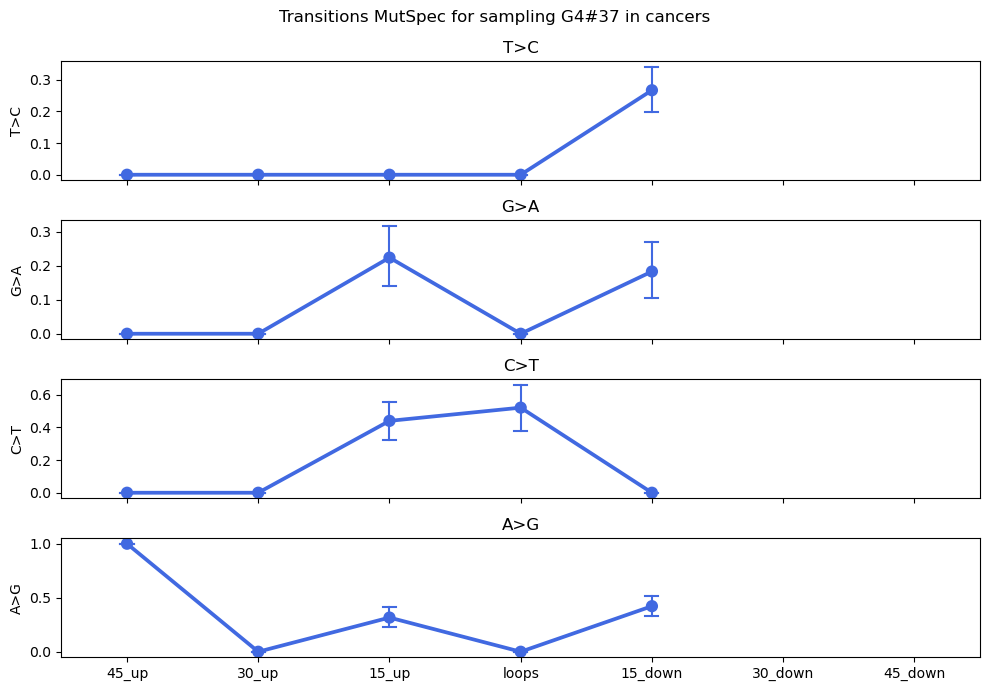

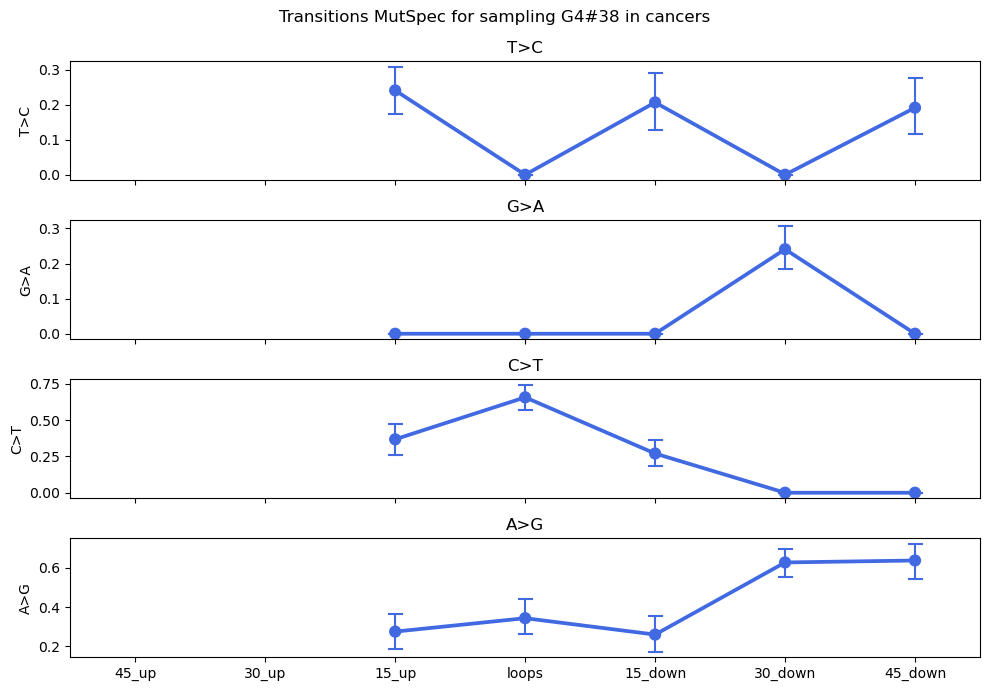

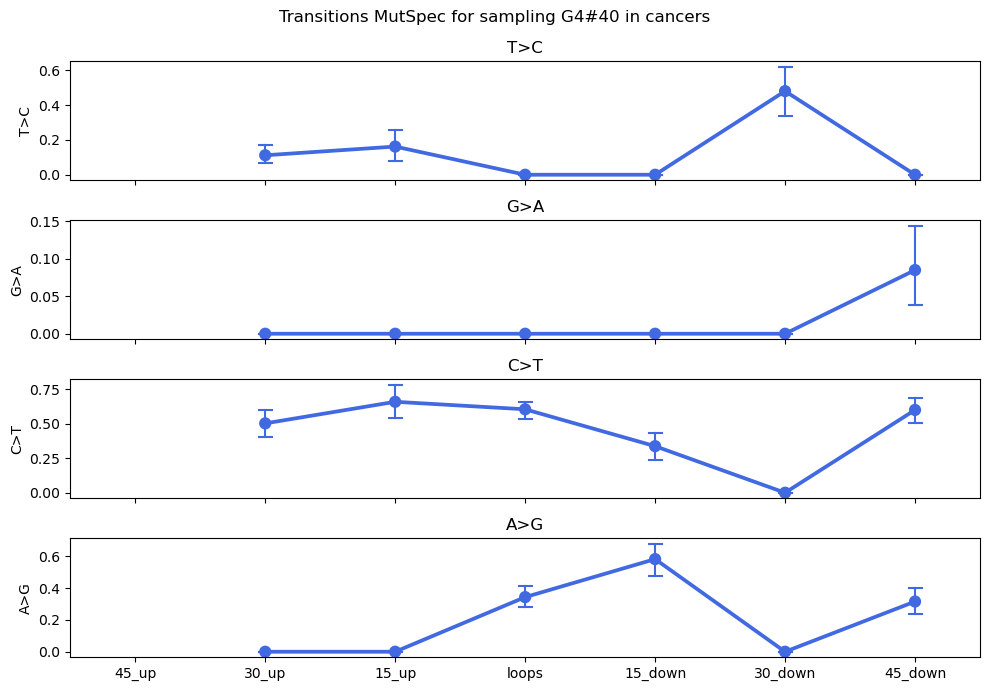

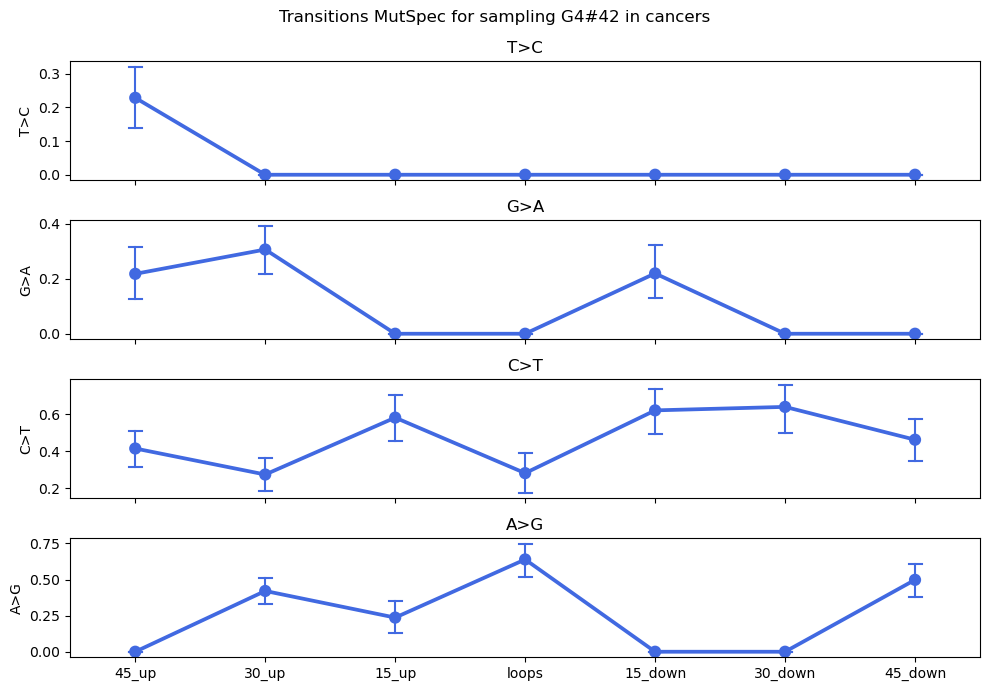

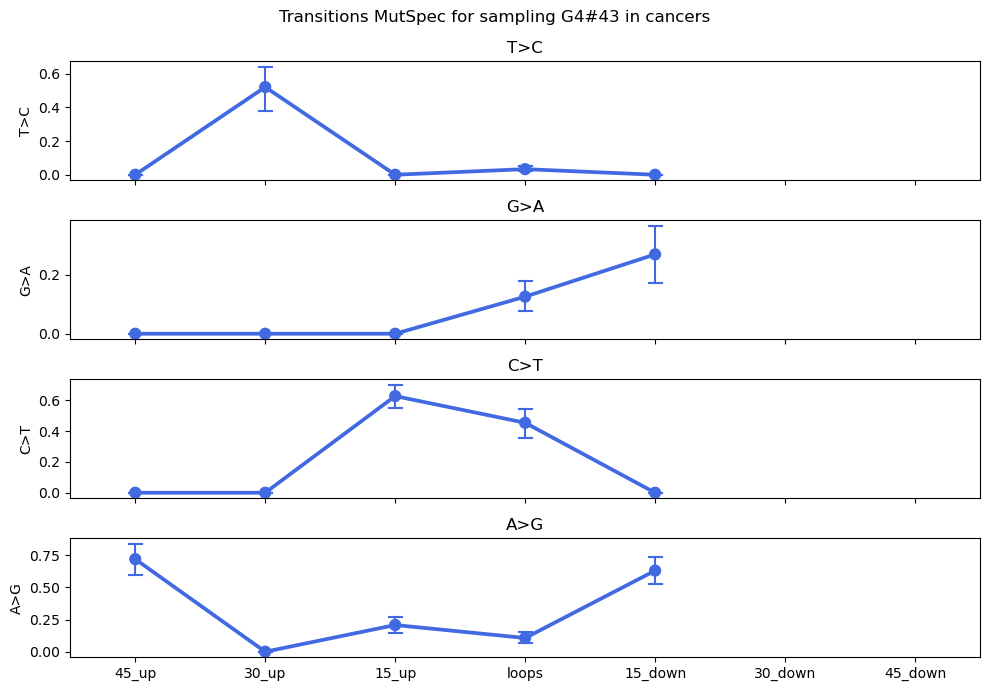

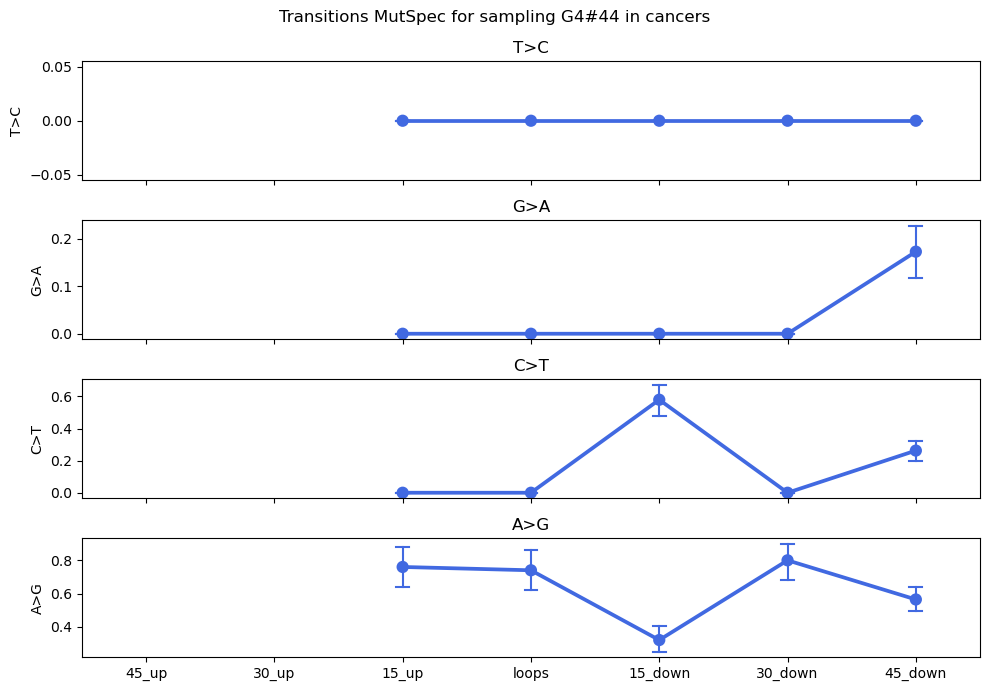

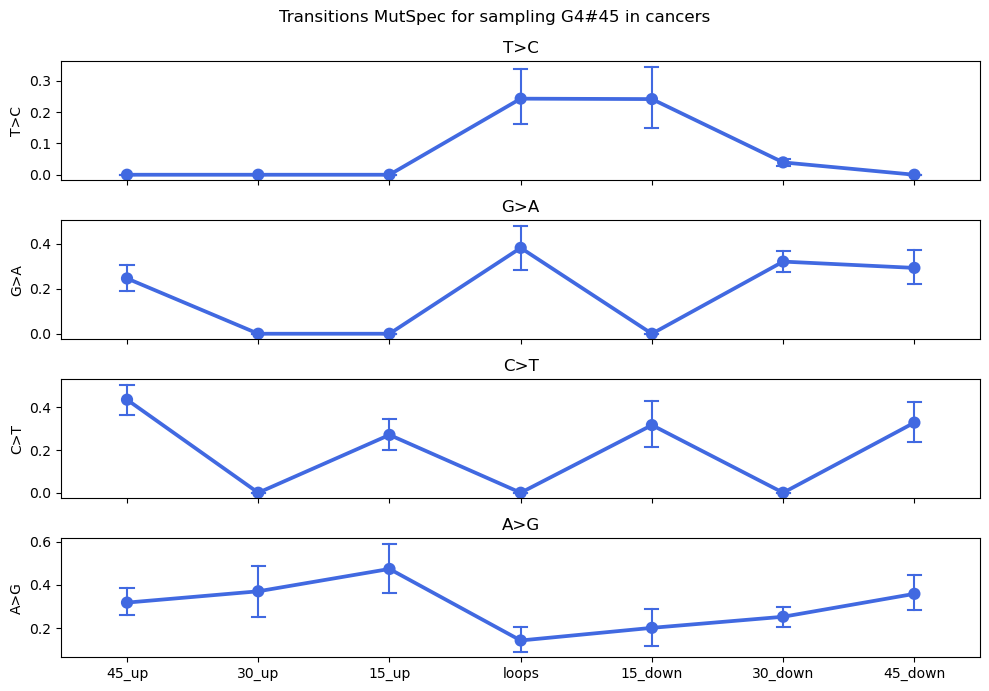

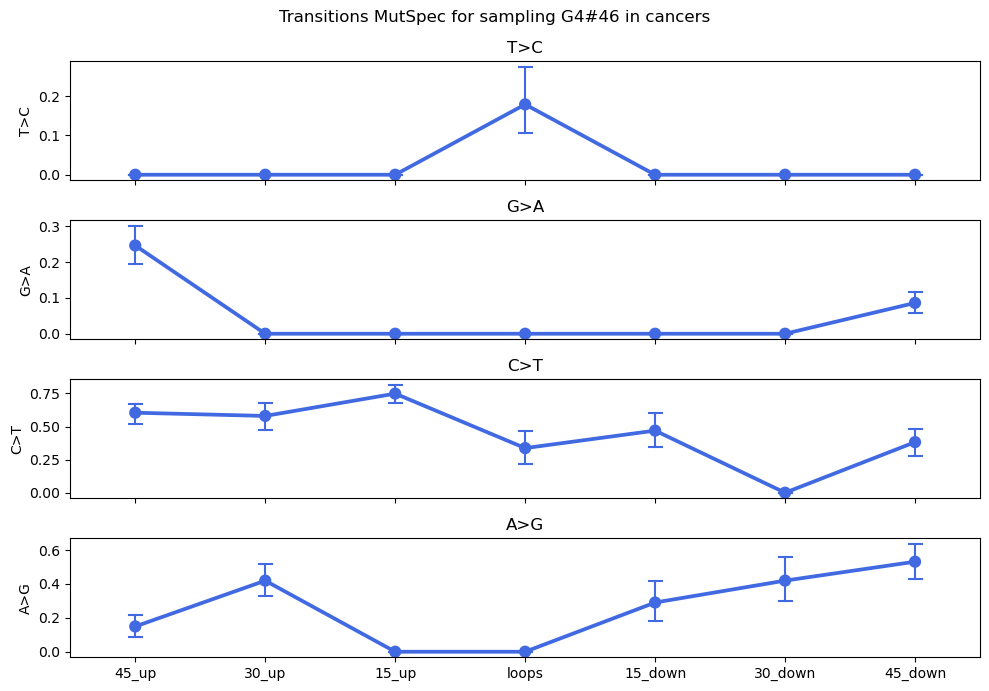

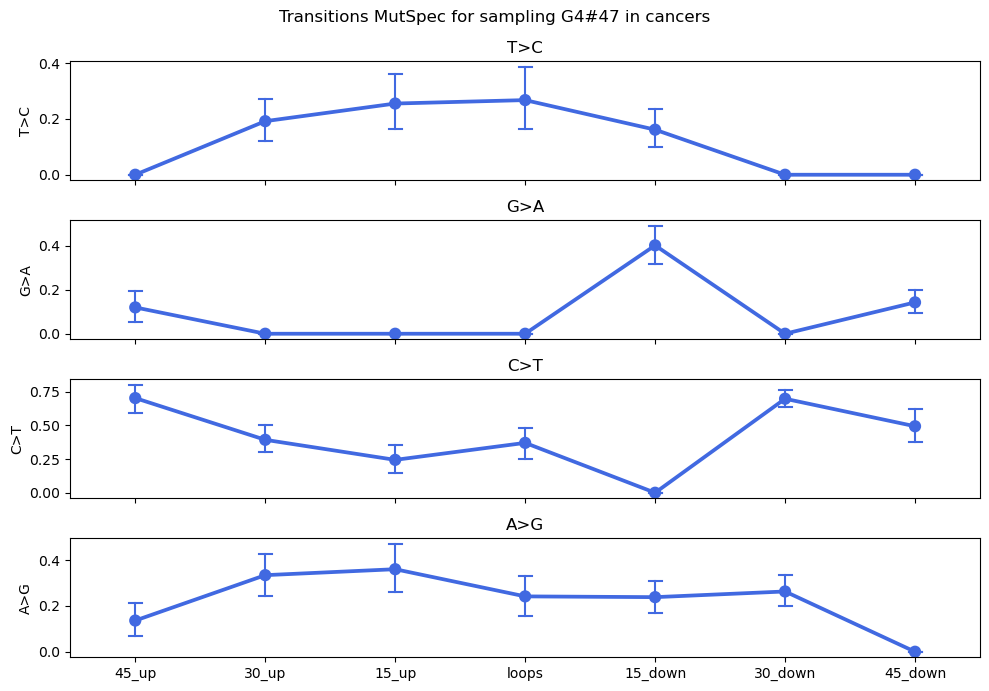

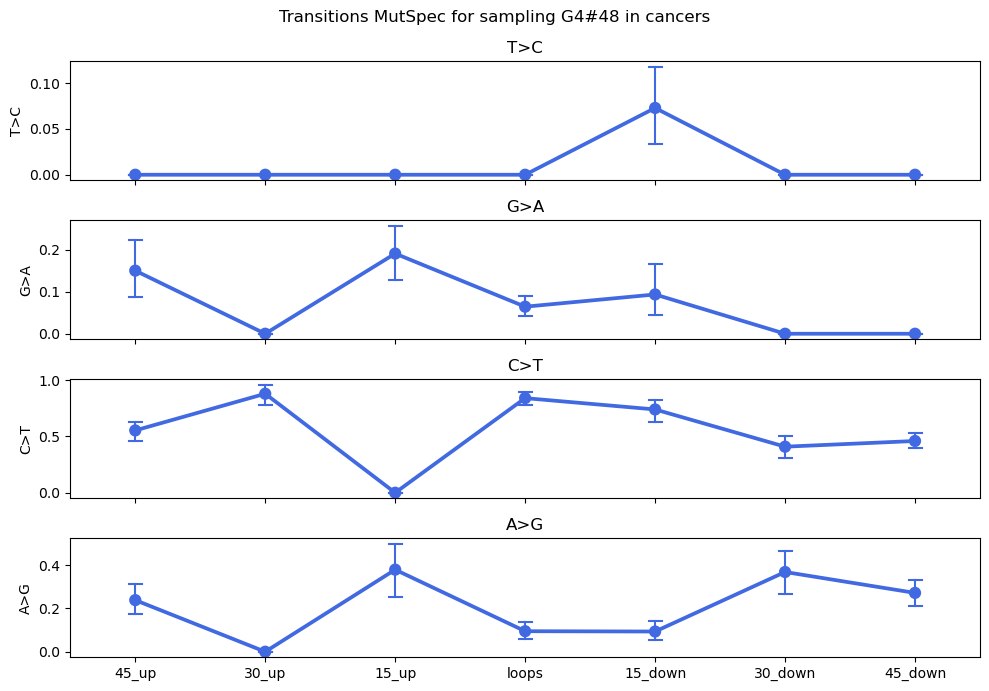

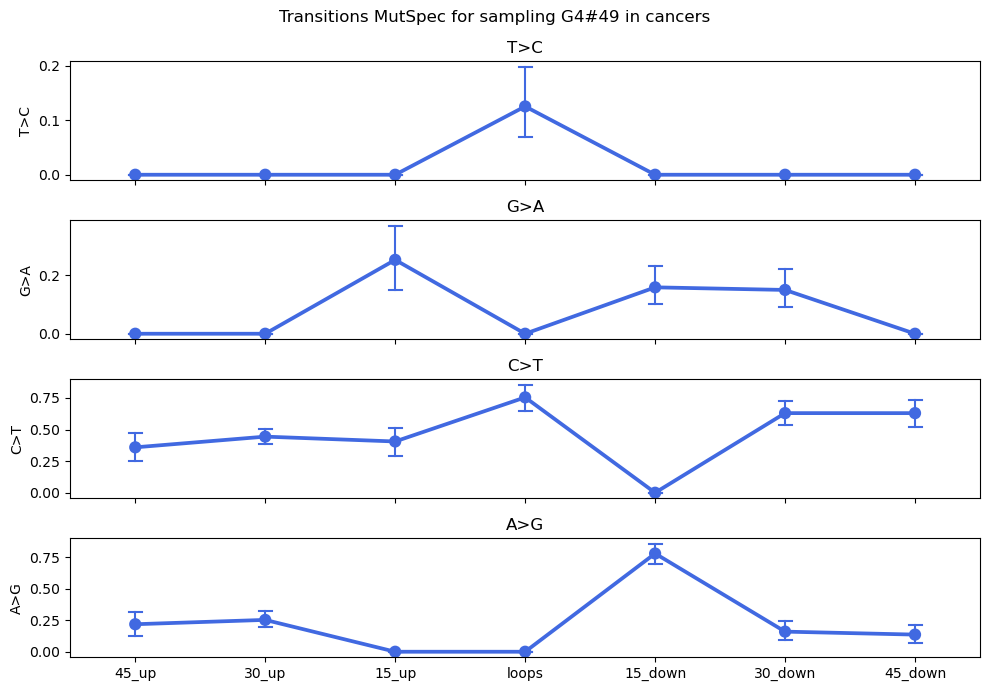

KeyboardInterrupt: 

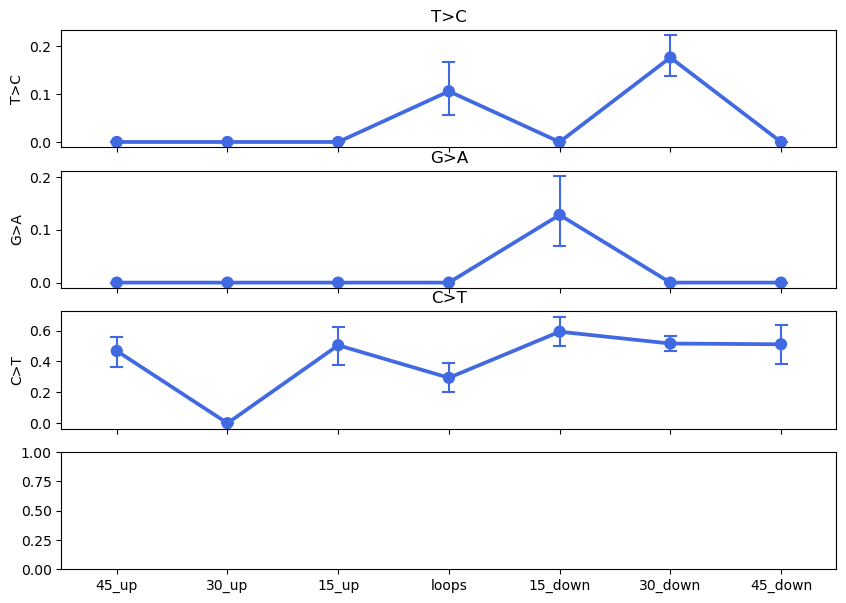

In [62]:
for G4_id in df_sample_norm_concat.G4_id.unique():
    fig, axs = plt.subplots(4, sharex=True,  figsize=(10, 7))
    mutations = ['T>C', 'G>A', 'C>T', 'A>G']
    
    colors = ['royalblue', 'darkorange', 'tomato', 'orchid']
    order = ['45_up', '30_up', '15_up', 'loops', '15_down', '30_down', '45_down']
    
    for i, mutation in enumerate(mutations):
        row = i % 4
        sns.pointplot(data=df_sample_norm_concat[df_sample_norm_concat['G4_id'] == G4_id], 
                     x=df_sample_norm_concat[df_sample_norm_concat['G4_id'] == G4_id]['side'], y=mutation, ax=axs[row], color=colors[0], order=order, capsize=.1, errwidth=1.5) \
            .set(title=mutation, xlabel=None)
    
    
    plt.suptitle(f'Transitions MutSpec for sampling G4#{G4_id} in cancers')
    plt.tight_layout()
    plt.show()